In [1]:
import numpy as np
import pandas as pd
import datatable as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Introduction

# Context

1. [Data Preparation](#1)
1. [Part 1: Display of Gestures](#2)
1. [Part 2: Piecewise Aggregate Approximation](#3)
1. [Part 2: Adaptive Piecewise Representation with Linear Regressor](#4)
1. [Part 2: Gesture Recognation Perspective](#5)

<a id="1"></a>
# Data Preparation

In [2]:
os.getcwd()

'C:\\Users\\bahad\\GitHub\\IE48B\\Homework1'

In [3]:
Folder_path="UWave-20211030T180805Z-001/UWave/"

In [4]:
x_train, y_train, z_train =pd.read_csv(f"{Folder_path}uWaveGestureLibrary_X_TRAIN.csv"),\
                           pd.read_csv(f"{Folder_path}uWaveGestureLibrary_Y_TRAIN.csv"),\
                           pd.read_csv(f"{Folder_path}uWaveGestureLibrary_Z_TRAIN.csv")

In [5]:
class_indicator=pd.DataFrame(x_train.iloc[:, 0])

In [6]:
acc_x=x_train.iloc[:,1:].T.cumsum().T.add_suffix("_X")
acc_y=y_train.iloc[:,1:].T.cumsum().T.add_suffix("_Y")
acc_z=z_train.iloc[:,1:].T.cumsum().T.add_suffix("_Z")

In [7]:
dataframes=[class_indicator, acc_x, acc_y, acc_z]

In [8]:
all_acc=pd.concat(dataframes, axis=1)

## Gesture Filter

In [9]:
def filter_data(ind_data, x_data, y_data, z_data, index):

    x_concat=pd.concat([ind_data,x_data], axis=1)
    x_filtered=x_concat[x_concat.iloc[:, 0]== index].iloc[:, 1:]
    
    y_concat=pd.concat([ind_data,y_data], axis=1)
    y_filtered=y_concat[y_concat.iloc[:, 0]== index].iloc[:, 1:]
    
    z_concat=pd.concat([ind_data,z_data], axis=1)
    z_filtered=z_concat[z_concat.iloc[:, 0]== index].iloc[:, 1:]
    
    return x_filtered, y_filtered, z_filtered

<a id="2"></a>
# Part 1: Display

In [10]:
import plotly.express as px

## Graph Display Function

In [11]:
def print_graph(x ,y, z, no):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax = Axes3D(fig)

    ax.scatter(x, y, z,)
    ax.set_title(f"Geture {no} Example")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    
    return plt.show()

## Gesture 1

In [12]:
x_1, y_1, z_1 = filter_data(class_indicator, acc_x, acc_y, acc_z, 1)

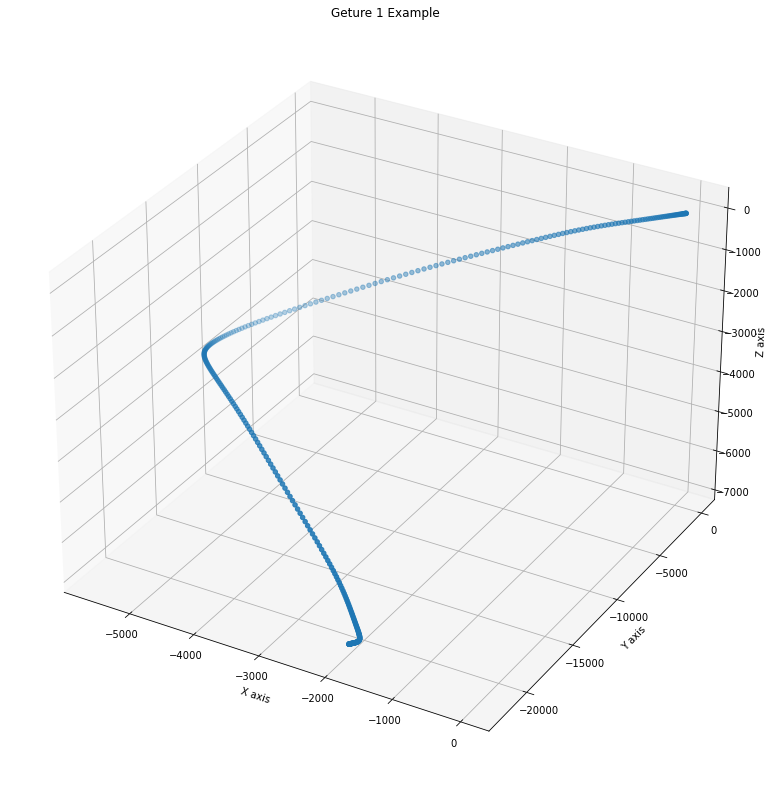

In [13]:
print_graph(x_1.T.cumsum().iloc[:, 0], y_1.T.cumsum().iloc[:, 0], z_1.T.cumsum().iloc[:, 0], 1)

## Plotly Plot

In order to analyze which value (velocity or position) was analyzed by looking with an interactive plot.

In [14]:
# fig1=px.scatter_3d(x=x_1.T.cumsum().iloc[:, 0], y=y_1.T.cumsum().iloc[:, 0], z=z_1.T.cumsum().iloc[:, 0],
#              labels=dict(x="X Axis", y="Y Axis", z="Z Axis"), title="Gesture 1 Example")
# fig1.update_traces(marker=dict(size=4,opacity=0.4))

## Gesture 2

In [15]:
x_2, y_2, z_2 = filter_data(class_indicator, acc_x, acc_y, acc_z, 2)

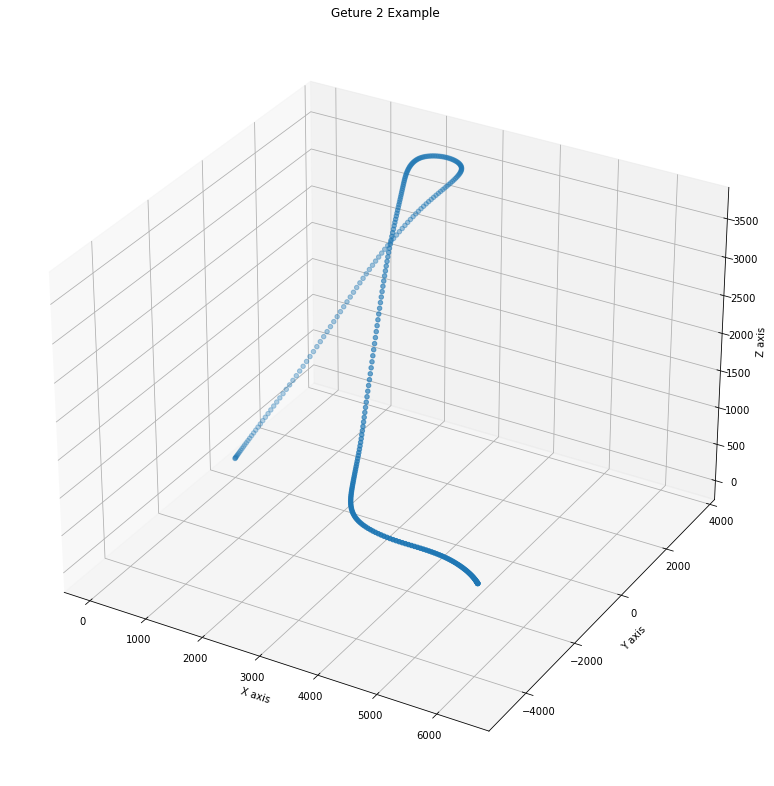

In [16]:
print_graph(x_2.T.cumsum().iloc[:, 0], y_2.T.cumsum().iloc[:, 0], z_2.T.cumsum().iloc[:, 0], 2)

## Gesture 3

In [17]:
x_3, y_3, z_3 = filter_data(class_indicator, acc_x, acc_y, acc_z, 3)

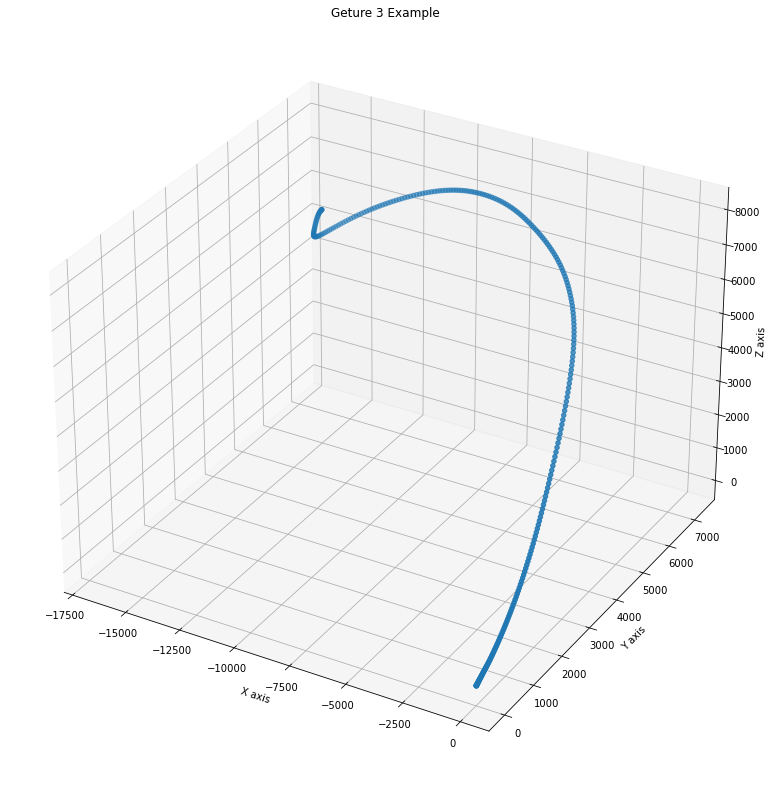

In [18]:
print_graph(x_3.T.cumsum().iloc[:, 0], y_3.T.cumsum().iloc[:, 0], z_3.T.cumsum().iloc[:, 0], 3)

## Gesture 4

In [19]:
x_4, y_4, z_4 = filter_data(class_indicator, acc_x, acc_y, acc_z, 4)

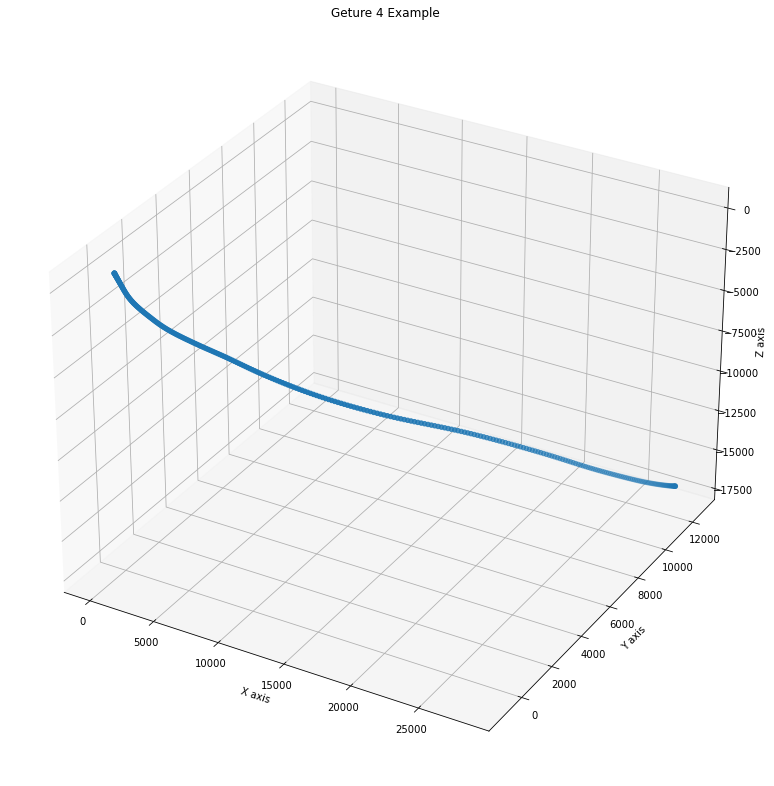

In [20]:
print_graph(x_4.T.cumsum().iloc[:, 0], y_4.T.cumsum().iloc[:, 0], z_4.T.cumsum().iloc[:, 0], 4)

## Gesture 5

In [21]:
x_5, y_5, z_5 = filter_data(class_indicator, acc_x, acc_y, acc_z, 5)

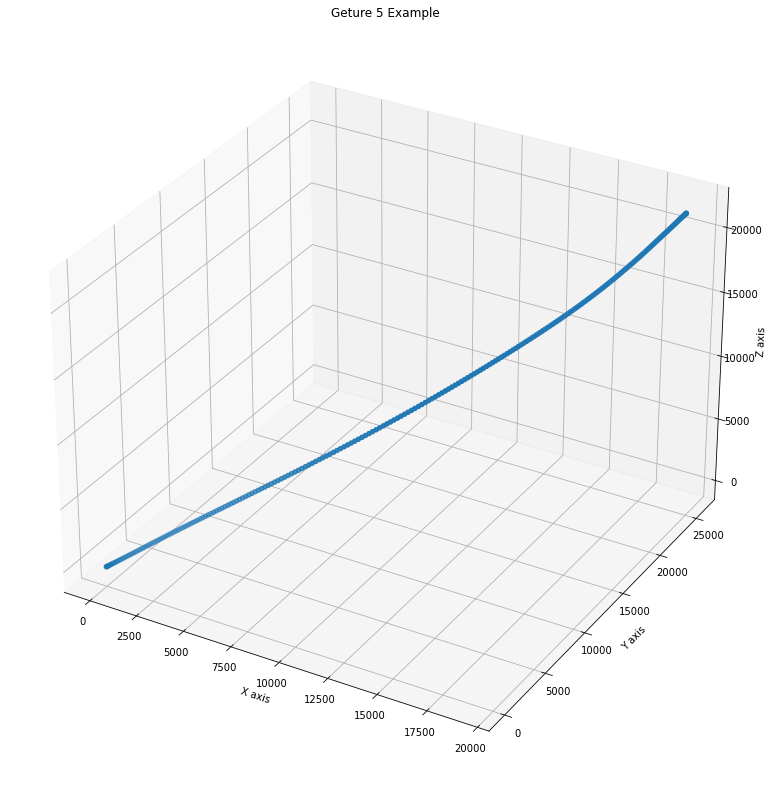

In [22]:
print_graph(x_5.T.cumsum().iloc[:, 0], y_5.T.cumsum().iloc[:, 0], z_5.T.cumsum().iloc[:, 0], 5)

## Gesture 6

In [23]:
x_6, y_6, z_6 = filter_data(class_indicator, acc_x, acc_y, acc_z, 6)

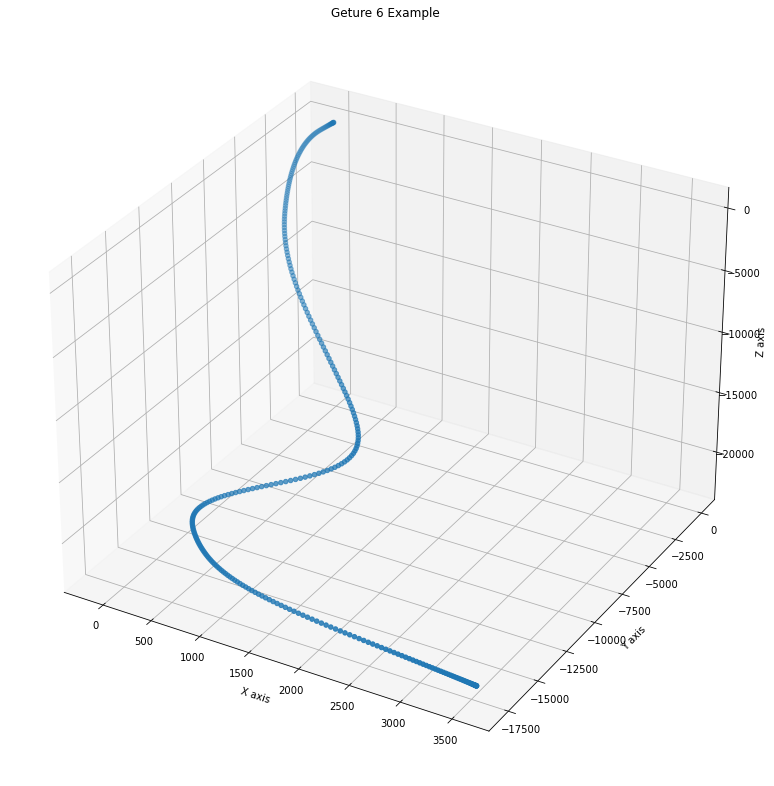

In [24]:
print_graph(x_6.T.cumsum().iloc[:, 0], y_6.T.cumsum().iloc[:, 0], z_6.T.cumsum().iloc[:, 0], 6)

## Gesture 7

In [25]:
x_7, y_7, z_7 = filter_data(class_indicator, acc_x, acc_y, acc_z, 7)

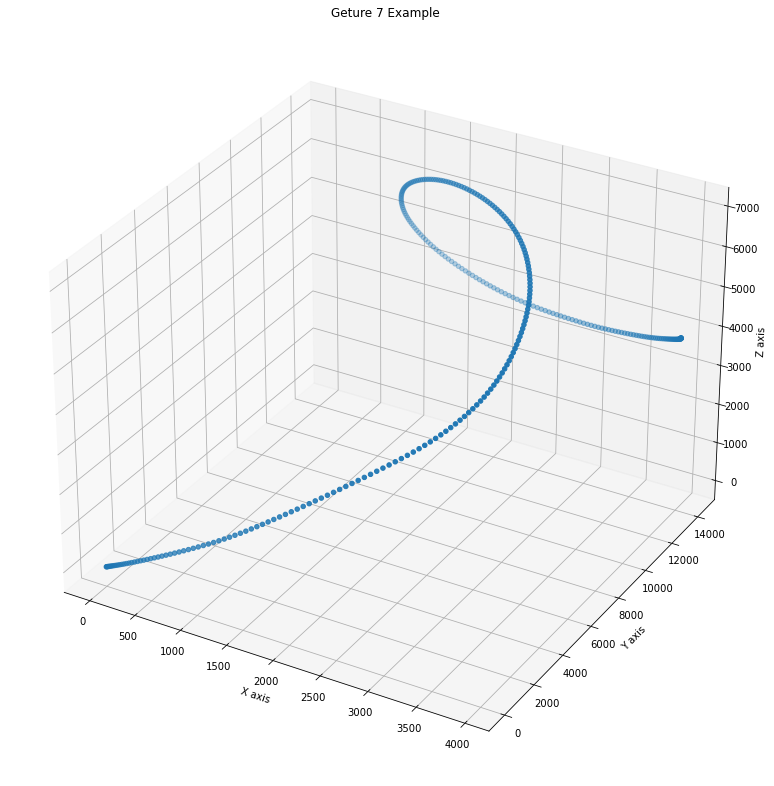

In [26]:
print_graph(x_7.T.cumsum().iloc[:, 0], y_7.T.cumsum().iloc[:, 0], z_7.T.cumsum().iloc[:, 0], 7)

## Gesture 8

In [27]:
x_8, y_8, z_8 = filter_data(class_indicator, acc_x, acc_y, acc_z, 8)

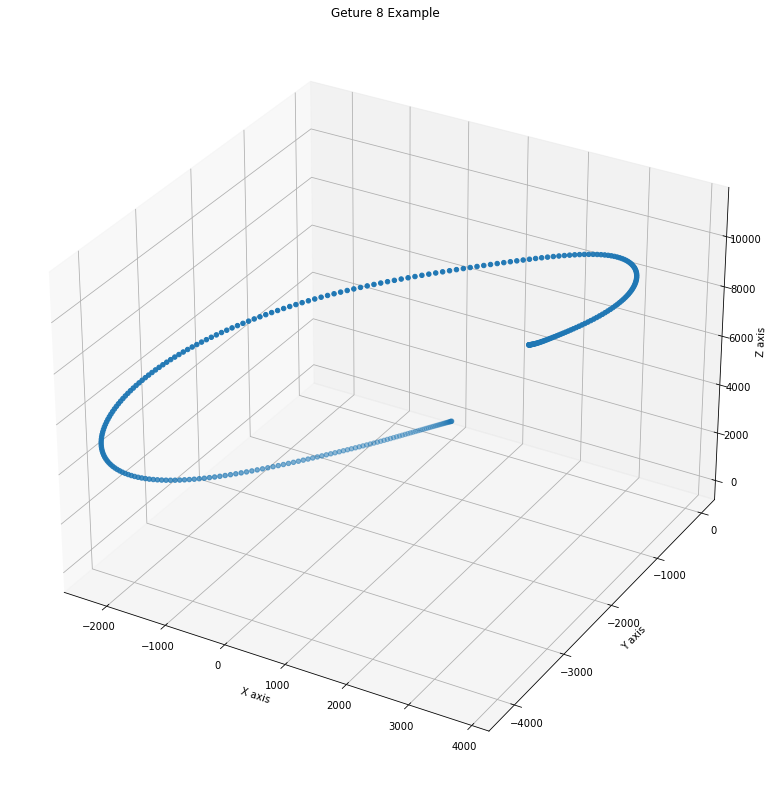

In [28]:
print_graph(x_8.T.cumsum().iloc[:, 0], y_8.T.cumsum().iloc[:, 0], z_8.T.cumsum().iloc[:, 0], 8)

# Part 2: 2 Representation Method

2 Different will be tried to represent existing dataset.

In [29]:
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize

<a id="3"></a>
# Piecewise Aggregate Approximation Function

There is 315 different time point in each axis, so it is hard to observe and analyze it by using Symbolic Aggregate approXimation(SAX) without Piecewise Aggregate Approximation(PAA). In this manner, SAX will be used with PAA in order to understand the symbols more easily. In addition, each axis will be constructed seperately.

In [30]:
def string_with_paa(dataset):
    length = dataset.shape[0]
    shape_information=[]
    value_information=[]
    
    for i in range(length):
        current_values=np.array(dataset.iloc[i, :])
        dat_znorm = znorm(current_values) # Normalized Data to easily control understand how to symbols are selected
        dat_paa = paa(current_values, 9) # Similar to dimension Reduction, Piecewise Aggregate Approximation (PAA) is used to get
                                     # a visiable result
        dat_zpaa= paa(dat_znorm, 9)
        value_information.append(list(dat_paa))
    
        strings=ts_to_string(dat_zpaa, cuts_for_asize(8))
        shape_information.append(list(strings))
            
    return shape_information, value_information

In [31]:
def majority_voting(dt):
    final_vote=[]
    for i in range(dt.shape[0]):
        if(dt.iloc[i,0]==dt.iloc[i,1]):
            final_vote.append(dt.iloc[i,0])
            
        elif(dt.iloc[i,0]==dt.iloc[i,2]):
            final_vote.append(dt.iloc[i,0])
            
        elif(dt.iloc[i,1]==dt.iloc[i,2]):
            final_vote.append(dt.iloc[i,1])
        
        else:
            mean_vote=round(((ord(dt.iloc[i,0])-96)+(ord(dt.iloc[i,1])-96)+(ord(dt.iloc[i,2])-96))/3)
            final_vote.append(chr(mean_vote+96))
    return final_vote

## Gesture 1 SAX with PAA

In [32]:
x_string_1, x_values_1=string_with_paa(x_1)
y_string_1, y_values_1=string_with_paa(y_1)
z_string_1, z_values_1=string_with_paa(z_1)

In [33]:
string_data_1 = [pd.DataFrame({"X":x_string_1[i], "Y":y_string_1[i], "Z":z_string_1[i]}) for i in range(x_1.shape[0])]

In [34]:
value_data_1 = [pd.DataFrame({"X":x_values_1[i], "Y":y_values_1[i], "Z":z_values_1[i]}) for i in range(x_1.shape[0])]

### Hard Voting 

In [35]:
for i in range(x_1.shape[0]):
    string_data_1[i]["hard_voting"]=majority_voting(string_data_1[i])

## Visual Control Gesture 1

One example implementation for new lines will be demonstrated at below. Remaning will be added to visualitation function in order to reduce repated codes for other Gestures.

In [36]:
def visualization(origin, created, gesture_no, ax_code, id_value):
    """ 
    x value is represented by 0
    y value is represented by 1
    z value is represented by 2
    id_value represent which item is selected(in sequence) in filtered dataset by gesture class information(V1 in intial data)
    """
    key_values = {"X": 0, "Y": 1, "Z":2}
    
    ax_sequence=key_values.get(ax_code)
    
    location=pd.DataFrame(origin.iloc[id_value, :]).reset_index(drop=True) #
    location.set_axis(["original_values"], axis=1, inplace=True)
    location.index+=1

    obtanied_locations=pd.DataFrame(created[id_value].iloc[:, ax_sequence])
    obtanied_locations.set_axis(["PAA_value"], axis=1, inplace=True)
    obtanied_locations.index+=1
    obtanied_locations.index*=35

    mergedDf = pd.merge(location, obtanied_locations, how="left", left_index=True, right_index=True)
    mergedDf.PAA_value.fillna(method="bfill", inplace=True)
    
    plt.figure(figsize=(14, 8)) 
    plt.plot(mergedDf["original_values"], label="True Values")
    plt.plot(mergedDf["PAA_value"], label="PAA Values")
    plt.title(f"{ax_code} axis of {gesture_no}. Gesture with PAA(SAX) \n({id_value+1}. Time Series in Gesture)")
    
    return(mergedDf)

### Example Dataframe Construction

In [37]:
example_x=pd.DataFrame(x_1.iloc[0, :]).reset_index(drop=True)
example_x.set_axis(["X_original"], axis=1, inplace=True)
example_x.index+=1

In [38]:
obtanied_x=pd.DataFrame(value_data_1[0].iloc[:, 0])
obtanied_x.set_axis(["X_PAA"], axis=1, inplace=True)
obtanied_x.index+=1
obtanied_x.index*=35

In [39]:
mergedDf = pd.merge(example_x, obtanied_x, how="left", left_index=True, right_index=True)

In [40]:
mergedDf.head(15)

X_original  X_PAA
1    -0.791447    NaN
2    -1.582894    NaN
3    -2.378767    NaN
4    -3.188832    NaN
5    -4.038062    NaN
6    -4.941527    NaN
7    -5.872673    NaN
8    -6.823277    NaN
9    -7.773880    NaN
10   -8.724483    NaN
11   -9.675087    NaN
12  -10.625690    NaN
13  -11.576294    NaN
14  -12.526897    NaN
15  -13.477500    NaN

### Fill of Na Values

In [41]:
mergedDf.X_PAA.fillna(method="bfill", inplace=True)

In [42]:
mergedDf.head(15)

X_original      X_PAA
1    -0.791447 -16.398346
2    -1.582894 -16.398346
3    -2.378767 -16.398346
4    -3.188832 -16.398346
5    -4.038062 -16.398346
6    -4.941527 -16.398346
7    -5.872673 -16.398346
8    -6.823277 -16.398346
9    -7.773880 -16.398346
10   -8.724483 -16.398346
11   -9.675087 -16.398346
12  -10.625690 -16.398346
13  -11.576294 -16.398346
14  -12.526897 -16.398346
15  -13.477500 -16.398346

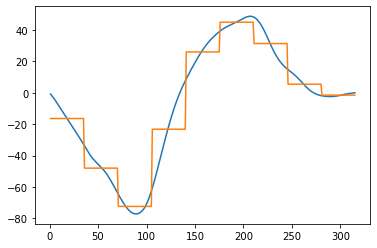

In [43]:
plt.plot(mergedDf["X_original"], label="True Values")
plt.plot(mergedDf["X_PAA"], label="PAA Values")

After showing each step, other pictures will be obtained by using visualization function.

## Visualization by function

All Gestures' axes will be controlled for 1 item in order to observe any problem for a specific gesture(like rapid changes). The main control of this is to understand the performance of the PAA in one dimension. The general performance of the function will be determined after controlling the second alternative on one axis visualization.

### X axis

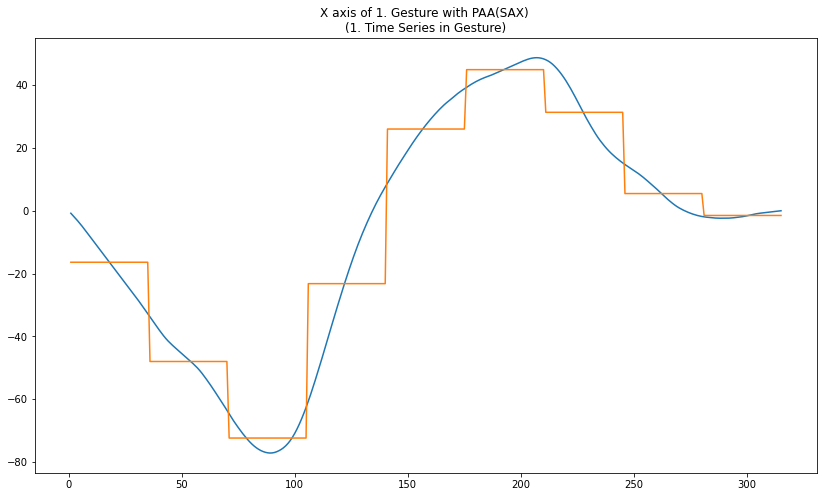

In [44]:
X_1_0=visualization(x_1, value_data_1, 1, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 1. Gesture, 0.item

### Y axis

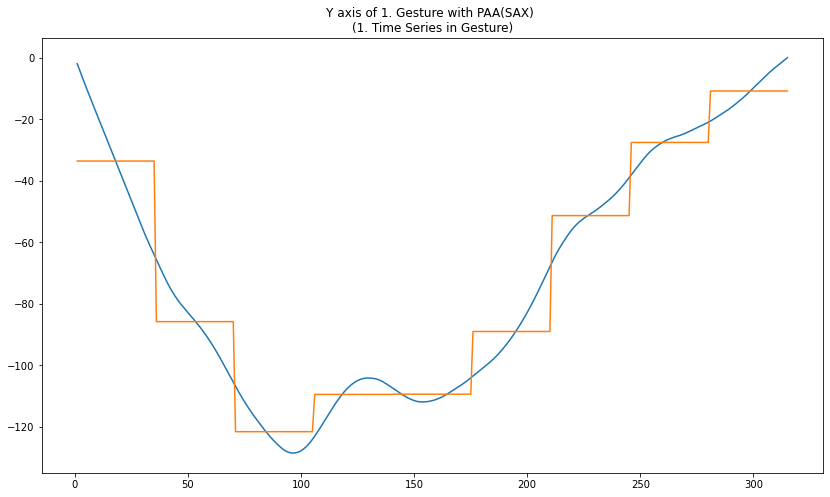

In [45]:
Y_1_0=visualization(y_1, value_data_1, 1, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 1. Gesture, 0.item

### Z axis

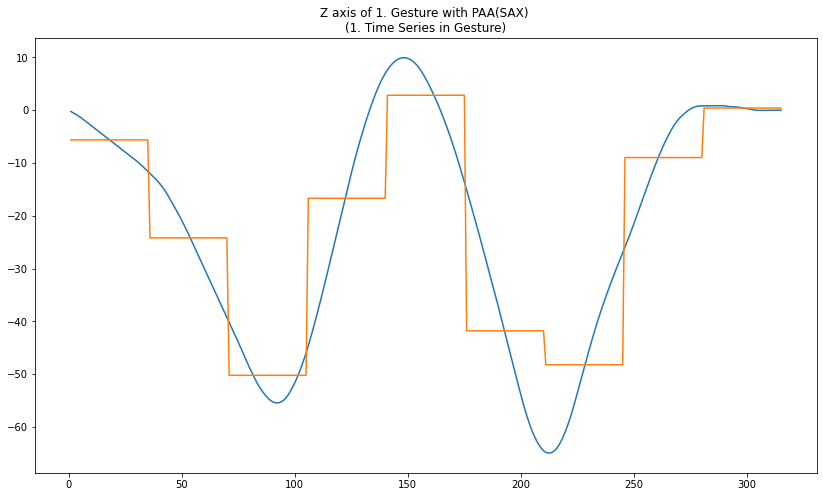

In [46]:
Z_1_0=visualization(z_1, value_data_1, 1, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 1. Gesture, 0.item

## Gesture 2 SAX with PAA

In [47]:
x_string_2, x_values_2=string_with_paa(x_2)
y_string_2, y_values_2=string_with_paa(y_2)
z_string_2, z_values_2=string_with_paa(z_2)

In [48]:
string_data_2 = [pd.DataFrame({"X":x_string_2[i], "Y":y_string_2[i], "Z":z_string_2[i]}) for i in range(x_2.shape[0])]

In [49]:
value_data_2 = [pd.DataFrame({"X":x_values_2[i], "Y":y_values_2[i], "Z":z_values_2[i]}) for i in range(x_2.shape[0])]

### Hard Voting 

In [50]:
for i in range(x_2.shape[0]):
    string_data_2[i]["hard_voting"]=majority_voting(string_data_2[i])

### X axis

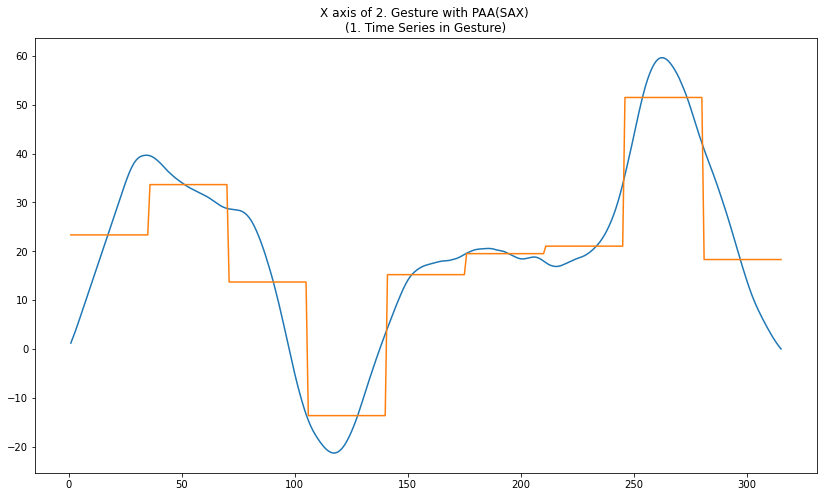

In [51]:
X_2_0=visualization(x_2, value_data_2, 2, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 2. Gesture, 0.item

### Y axis

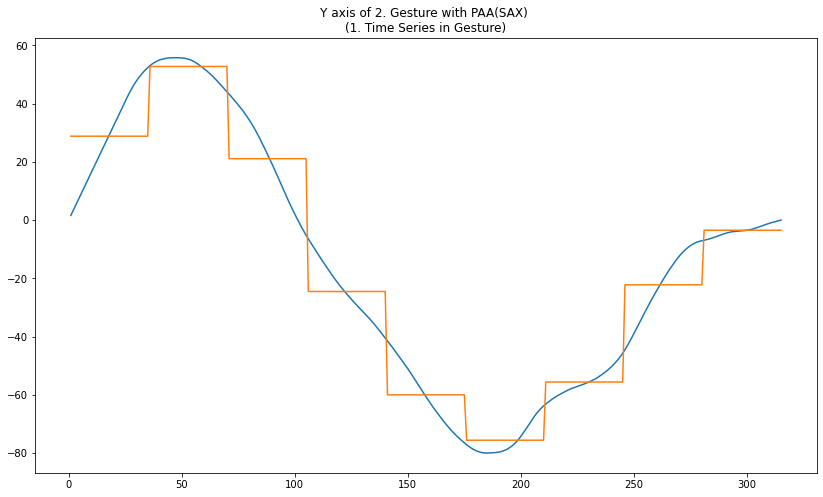

In [52]:
Y_2_0=visualization(y_2, value_data_2, 2, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 2. Gesture, 0.item

### Z axis

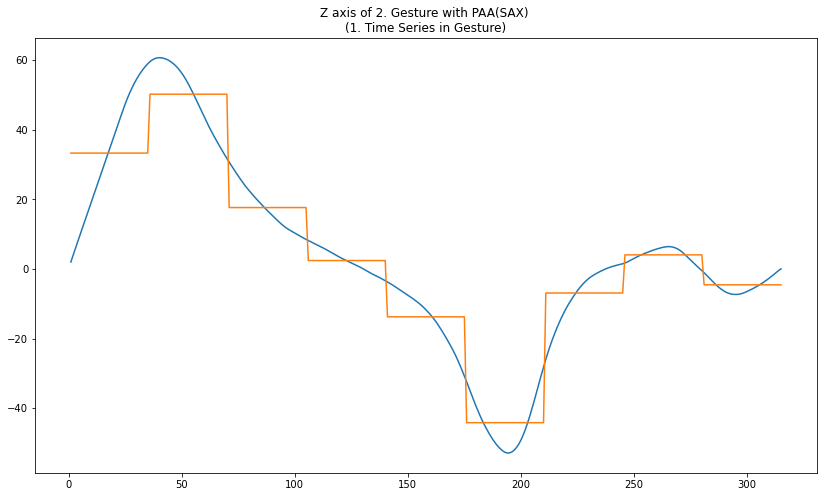

In [53]:
Z_2_0=visualization(z_2, value_data_2, 2, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 2. Gesture, 0.item

## Gesture 3 SAX with PAA

In [54]:
x_string_3, x_values_3=string_with_paa(x_3)
y_string_3, y_values_3=string_with_paa(y_3)
z_string_3, z_values_3=string_with_paa(z_3)

In [55]:
string_data_3 = [pd.DataFrame({"X":x_string_3[i], "Y":y_string_3[i], "Z":z_string_3[i]}) for i in range(x_3.shape[0])]

In [56]:
value_data_3 = [pd.DataFrame({"X":x_values_3[i], "Y":y_values_3[i], "Z":z_values_3[i]}) for i in range(x_3.shape[0])]

### Hard Voting 

In [57]:
for i in range(x_3.shape[0]):
    string_data_3[i]["hard_voting"]=majority_voting(string_data_3[i])

### X axis

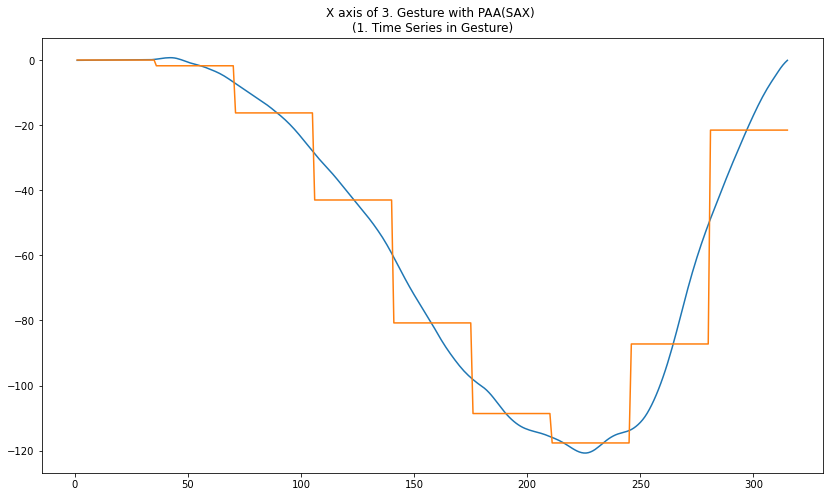

In [58]:
X_3_0=visualization(x_3, value_data_3, 3, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 3. Gesture, 0.item

### Y axis

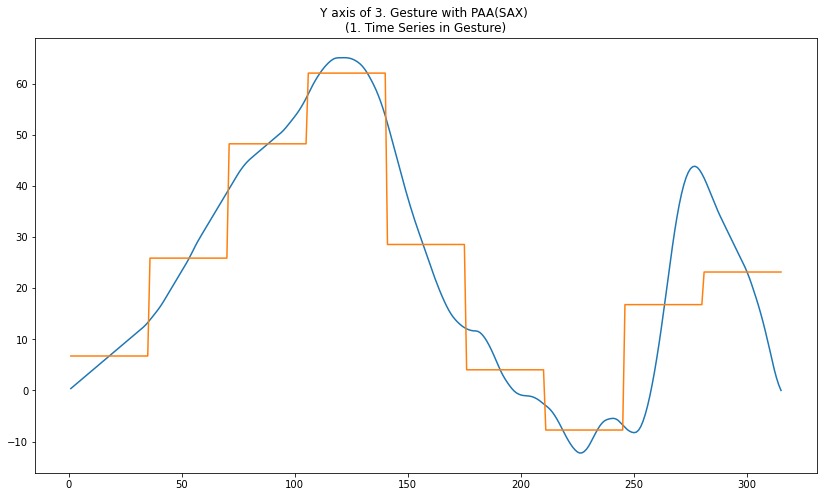

In [59]:
Y_3_0=visualization(y_3, value_data_3, 3, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 3. Gesture, 0.item

### Z axis

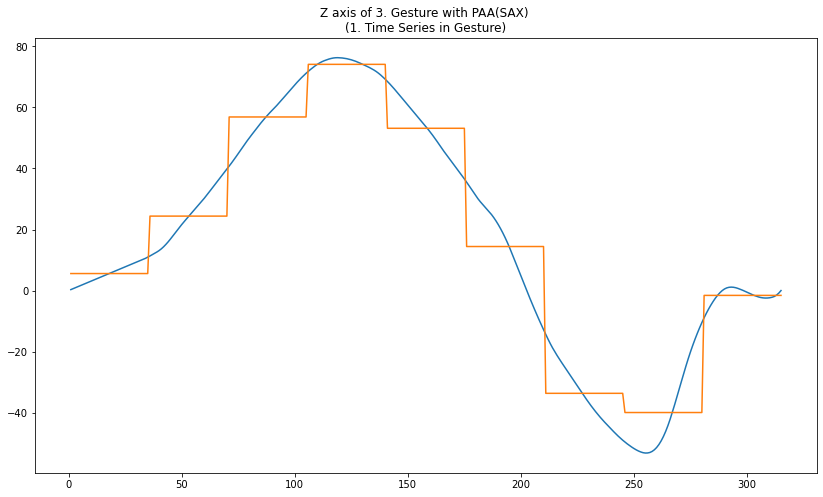

In [60]:
Z_3_0=visualization(z_3, value_data_3, 3, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 3. Gesture, 0.item

## Gesture 4 SAX with PAA

In [61]:
x_string_4, x_values_4=string_with_paa(x_4)
y_string_4, y_values_4=string_with_paa(y_4)
z_string_4, z_values_4=string_with_paa(z_4)

In [62]:
string_data_4 = [pd.DataFrame({"X":x_string_4[i], "Y":y_string_4[i], "Z":z_string_4[i]}) for i in range(x_4.shape[0])]

In [63]:
value_data_4 = [pd.DataFrame({"X":x_values_4[i], "Y":y_values_4[i], "Z":z_values_4[i]}) for i in range(x_4.shape[0])]

### Hard Voting 

In [64]:
for i in range(x_4.shape[0]):
    string_data_4[i]["hard_voting"]=majority_voting(string_data_4[i])

### X axis

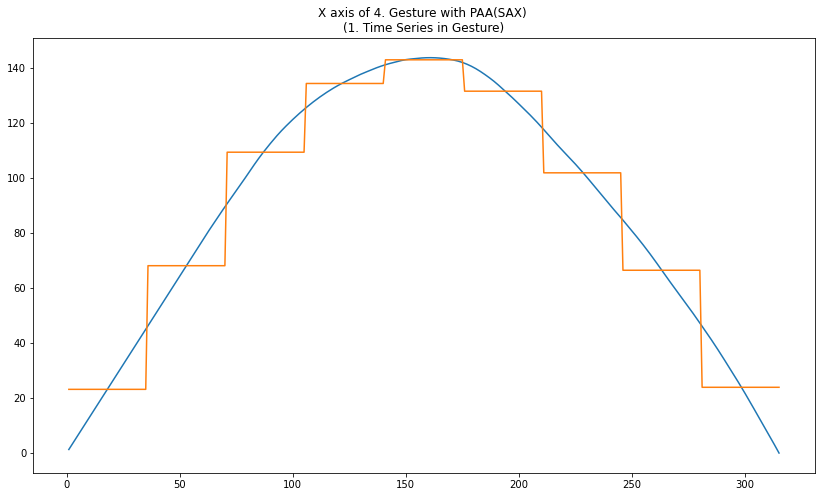

In [65]:
X_4_0=visualization(x_4, value_data_4, 4, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 4. Gesture, 0.item

### Y axis

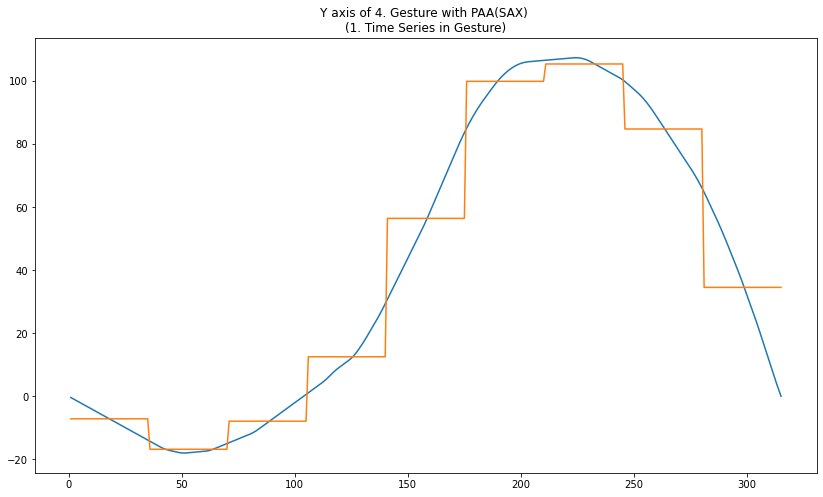

In [66]:
Y_4_0=visualization(y_4, value_data_4, 4, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 4. Gesture, 0.item

### Z axis

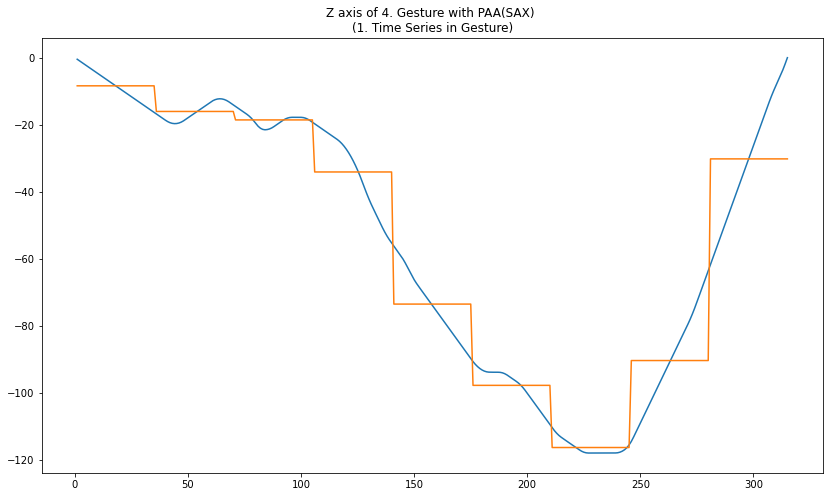

In [67]:
Z_4_0=visualization(z_4, value_data_4, 4, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 4. Gesture, 0.item

## Gesture 5 SAX with PAA

In [68]:
x_string_5, x_values_5=string_with_paa(x_5)
y_string_5, y_values_5=string_with_paa(y_5)
z_string_5, z_values_5=string_with_paa(z_5)

In [69]:
string_data_5 = [pd.DataFrame({"X":x_string_5[i], "Y":y_string_5[i], "Z":z_string_5[i]}) for i in range(x_5.shape[0])]

In [70]:
value_data_5 = [pd.DataFrame({"X":x_values_5[i], "Y":y_values_5[i], "Z":z_values_5[i]}) for i in range(x_5.shape[0])]

### Hard Voting 

In [71]:
for i in range(x_5.shape[0]):
    string_data_5[i]["hard_voting"]=majority_voting(string_data_5[i])

### X axis

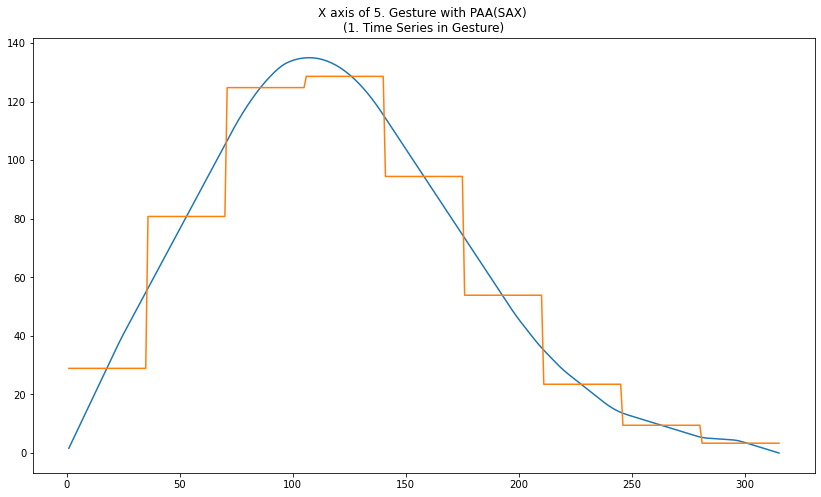

In [72]:
X_5_0=visualization(x_5, value_data_5, 5, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 5. Gesture, 0.item

### Y axis

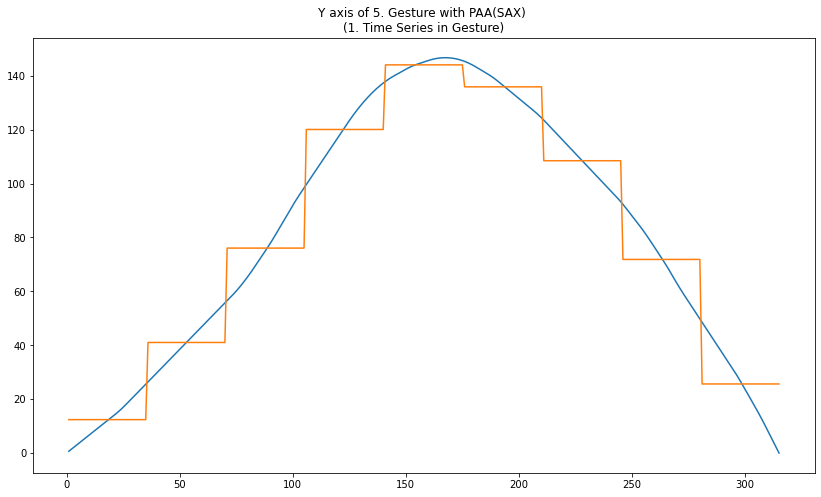

In [73]:
Y_5_0=visualization(y_5, value_data_5, 5, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 5. Gesture, 0.item

### Z axis

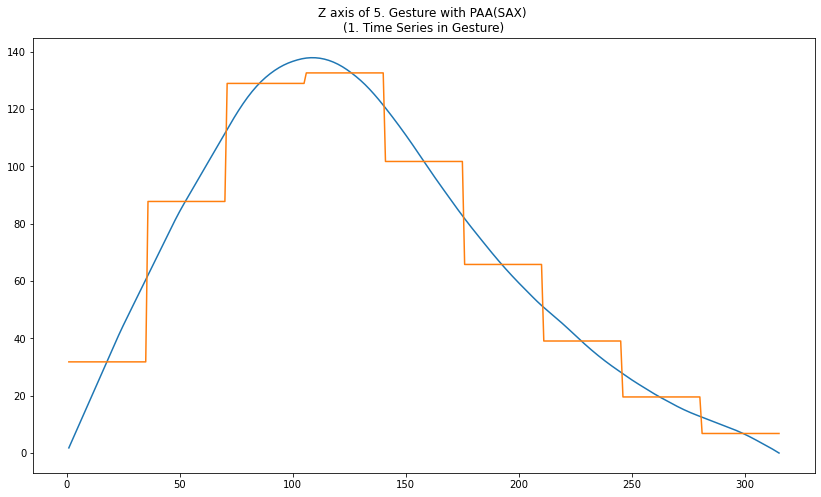

In [74]:
Z_5_0=visualization(z_5, value_data_5, 5, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 5. Gesture, 0.item

## Gesture 6 SAX with PAA

In [75]:
x_string_6, x_values_6=string_with_paa(x_6)
y_string_6, y_values_6=string_with_paa(y_6)
z_string_6, z_values_6=string_with_paa(z_6)

In [76]:
string_data_6 = [pd.DataFrame({"X":x_string_6[i], "Y":y_string_6[i], "Z":z_string_6[i]}) for i in range(x_6.shape[0])]

In [77]:
value_data_6 = [pd.DataFrame({"X":x_values_6[i], "Y":y_values_6[i], "Z":z_values_6[i]}) for i in range(x_6.shape[0])]

### Hard Voting 

In [78]:
for i in range(x_6.shape[0]):
    string_data_6[i]["hard_voting"]=majority_voting(string_data_6[i])

### X axis

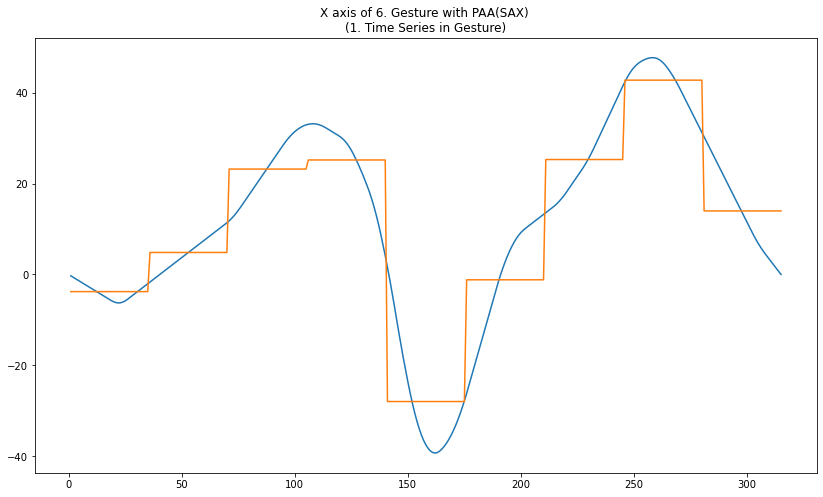

In [79]:
X_6_0=visualization(x_6, value_data_6, 6, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 6. Gesture, 0.item

### Y axis

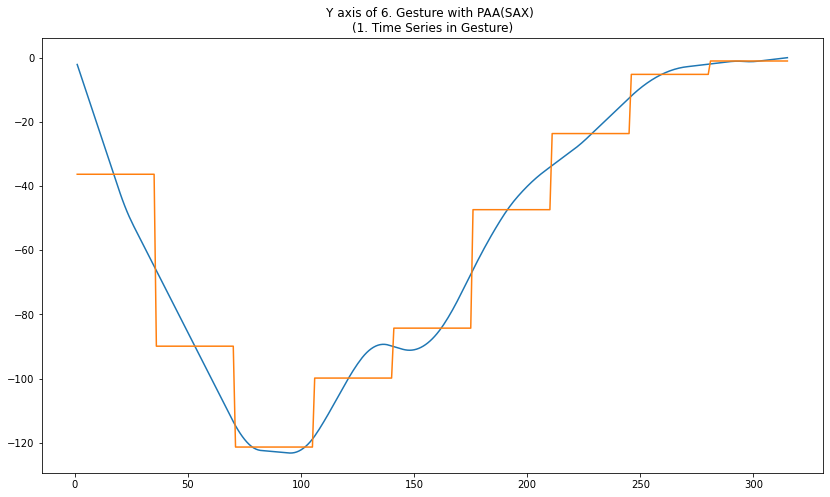

In [80]:
Y_6_0=visualization(y_6, value_data_6, 6, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 6. Gesture, 0.item

### Z axis

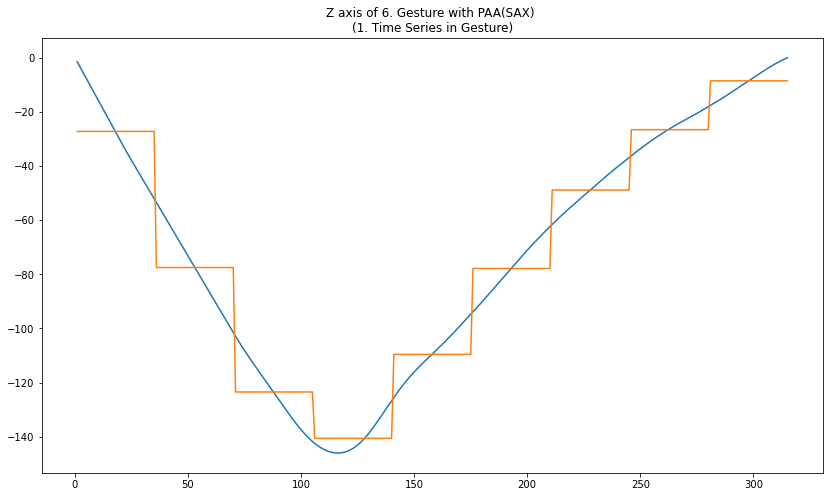

In [81]:
Z_6_0=visualization(z_6, value_data_6, 6, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 6. Gesture, 0.item

## Gesture 7 SAX with PAA

In [82]:
x_string_7, x_values_7=string_with_paa(x_7)
y_string_7, y_values_7=string_with_paa(y_7)
z_string_7, z_values_7=string_with_paa(z_7)

In [83]:
string_data_7 = [pd.DataFrame({"X":x_string_7[i], "Y":y_string_7[i], "Z":z_string_7[i]}) for i in range(x_7.shape[0])]

In [84]:
value_data_7 = [pd.DataFrame({"X":x_values_7[i], "Y":y_values_7[i], "Z":z_values_7[i]}) for i in range(x_7.shape[0])]

### Hard Voting 

In [85]:
for i in range(x_7.shape[0]):
    string_data_7[i]["hard_voting"]=majority_voting(string_data_7[i])

### X axis

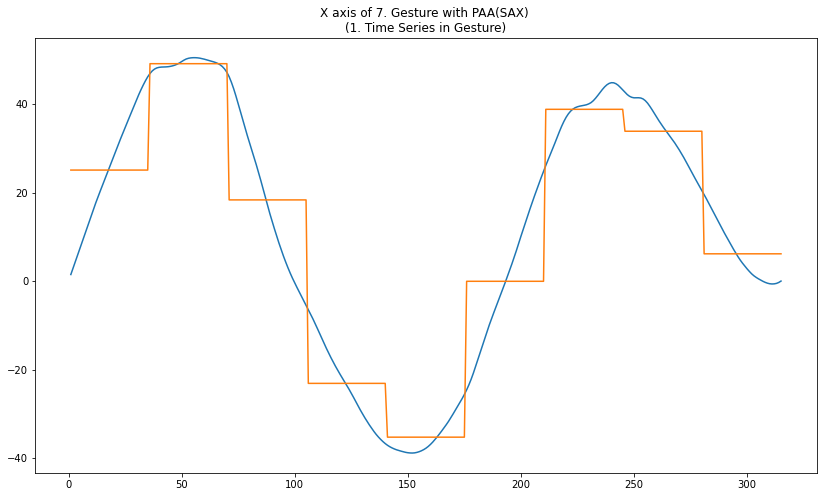

In [86]:
X_7_0=visualization(x_7, value_data_7, 7, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 7. Gesture, 0.item

### Y axis

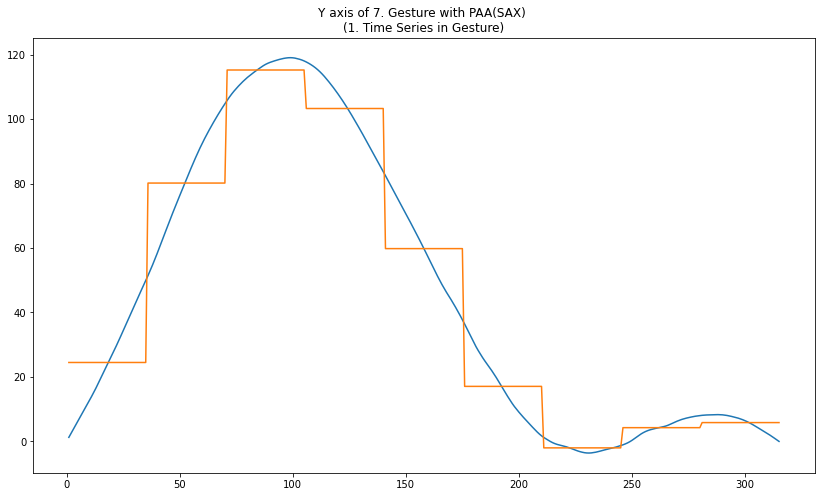

In [87]:
Y_7_0=visualization(y_7, value_data_7, 7, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 7. Gesture, 0.item

### Z axis

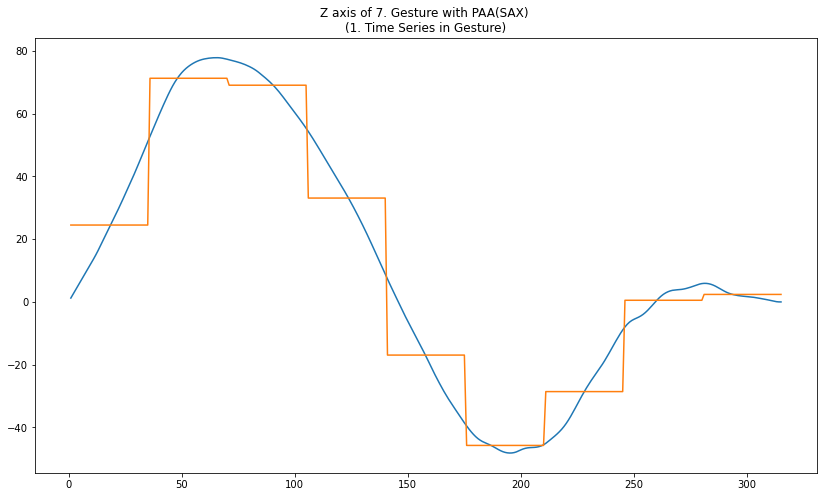

In [88]:
Z_7_0=visualization(z_7, value_data_7, 7, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 7. Gesture, 0.item

## Gesture 8 SAX with PAA

In [89]:
x_string_8, x_values_8=string_with_paa(x_8)
y_string_8, y_values_8=string_with_paa(y_8)
z_string_8, z_values_8=string_with_paa(z_8)

In [90]:
string_data_8 = [pd.DataFrame({"X":x_string_8[i], "Y":y_string_8[i], "Z":z_string_8[i]}) for i in range(x_8.shape[0])]

In [91]:
value_data_8 = [pd.DataFrame({"X":x_values_8[i], "Y":y_values_8[i], "Z":z_values_8[i]}) for i in range(x_8.shape[0])]

### Hard Voting 

In [92]:
for i in range(x_8.shape[0]):
    string_data_8[i]["hard_voting"]=majority_voting(string_data_8[i])

### X axis

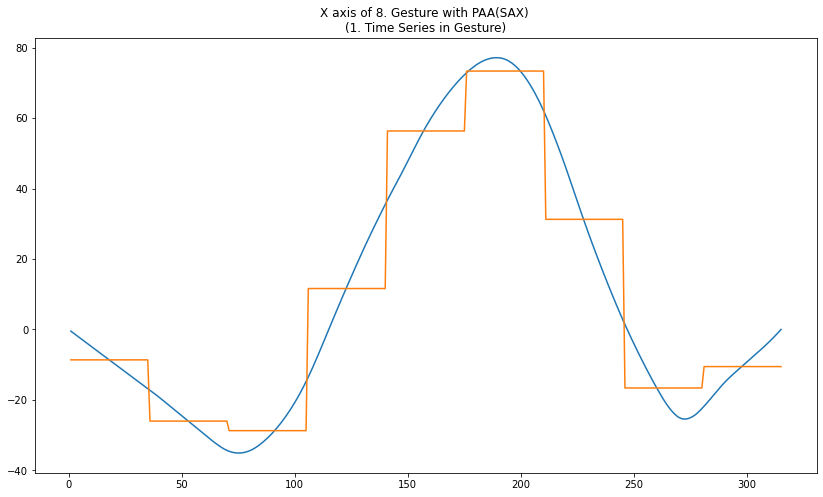

In [93]:
X_8_0=visualization(x_8, value_data_8, 8, "X", 0) #Returned Dataset Represent the required dataframe, X axis, 8. Gesture, 0.item

### Y axis

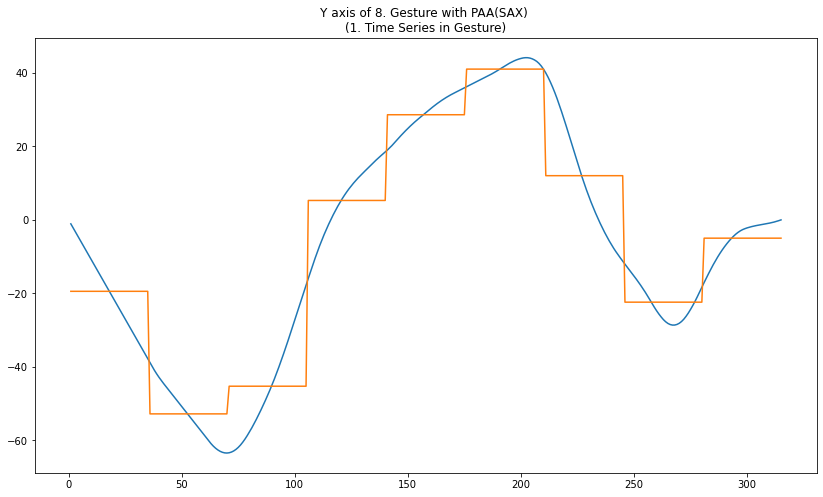

In [94]:
Y_8_0=visualization(y_8, value_data_8, 8, "Y", 0) #Returned Dataset Represent the required dataframe, Y axis, 8. Gesture, 0.item

### Z axis

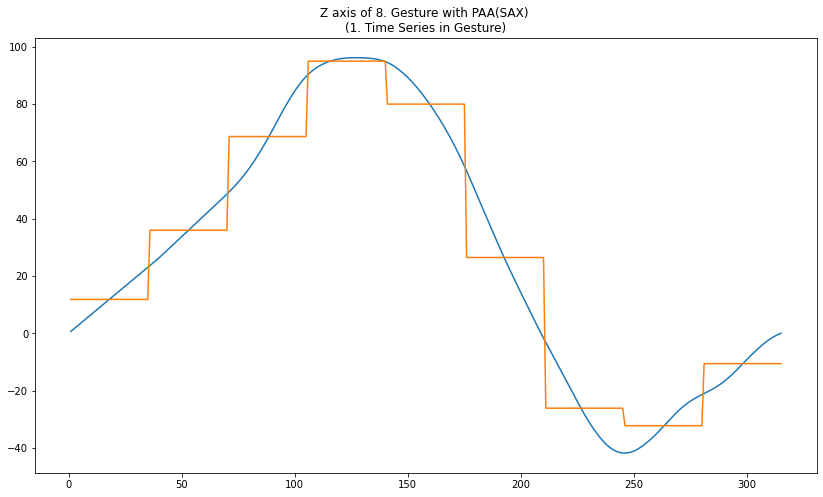

In [95]:
Z_8_0=visualization(z_8, value_data_8, 8, "Z", 0) #Returned Dataset Represent the required dataframe, Z axis, 8. Gesture, 0.item

# General Comment for Axis Representation

If there is an huge increase or decrease it is hard to represent this period by a single line. This problem can be handled by increasing the number of slot bu it can cause an overfitting problem. In addition, it is hard to understand the gesture by seperately looking the axis information. Final Gesture recognition will be handled at the end of the notebook by using moderate hard majority voting technique. In addition, numerical values didn't calculated because **only visual inspection was demanded in homework description.** 

<a id="4"></a>
# Adaptive Piecewise Representation with Linear Regressor

In [96]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [97]:
from sklearn.decomposition import PCA

In [98]:
def decision_tree(model, id_value, dataset):
    time=dataset[id_value][["time"]]
    values=dataset[id_value][["values"]]
    model.fit(time, values)
    
    predictions=model.predict(time)
    
    return predictions

In [99]:
def visualization_regressor(origin, created, gesture_no, ax_code, id_value):
    """ 
    x value is represented by 0
    y value is represented by 1
    z value is represented by 2
    id_value represent which item is selected(in sequence) in filtered dataset by gesture class information(V1 in intial data)
    """
    key_values = {"X": 0, "Y": 1, "Z":2}
    
    ax_sequence=key_values.get(ax_code)
    
    location=pd.DataFrame(origin.loc[:, "values"]).reset_index(drop=True) #
    location.set_axis(["original_values"], axis=1, inplace=True)
    location.index+=1

    obtanied_locations=pd.DataFrame(created)
    obtanied_locations.set_axis(["Regressor_value"], axis=1, inplace=True)
    obtanied_locations.index+=1
    mergedDf = pd.merge(location, obtanied_locations, how="left", left_index=True, right_index=True)

    plt.figure(figsize=(14, 8)) 
    plt.plot(mergedDf["original_values"], label="True Values")
    plt.plot(mergedDf["Regressor_value"], label="Regressor Value")
    plt.title(f"{ax_code} axis of {gesture_no}. Gesture with Regressor \n({id_value+1}. Time Series in Gesture)")
    
    return(mergedDf)

# Gesture 1 with Regression Tree

In [100]:
x_1_r=[pd.DataFrame({"time":range(1, len(x_1.T.iloc[:, i])+1), "values":x_1.T.iloc[:, i]}) for i in range(x_1.shape[0])]
y_1_r=[pd.DataFrame({"time":range(1, len(y_1.T.iloc[:, i])+1), "values":y_1.T.iloc[:, i]}) for i in range(y_1.shape[0])]
z_1_r=[pd.DataFrame({"time":range(1, len(z_1.T.iloc[:, i])+1), "values":z_1.T.iloc[:, i]}) for i in range(z_1.shape[0])]

## Individual Decision Models

In [101]:
tree_reg_x_1 = [DecisionTreeRegressor(max_depth=3) for i in range(x_1.shape[0])]
tree_reg_y_1 = [DecisionTreeRegressor(max_depth=3) for i in range(x_1.shape[0])]
tree_reg_z_1 = [DecisionTreeRegressor(max_depth=3) for i in range(x_1.shape[0])]

In [102]:
x_1_0_reg_pred=decision_tree(tree_reg_x_1[0], 0, x_1_r)
y_1_0_reg_pred=decision_tree(tree_reg_y_1[0], 0, y_1_r)
z_1_0_reg_pred=decision_tree(tree_reg_z_1[0], 0, z_1_r)

## PCA for Gesture 1

In [103]:
pca_1 = [pd.DataFrame({"time":x_1_r[i].iloc[:, 0].values,
                         "values_x":x_1_r[i].iloc[:, 1].values,
                         "values_y":y_1_r[i].iloc[:, 1].values,
                         "values_z":z_1_r[i].iloc[:, 1].values,})  for i in range(x_1.shape[0])]

In [104]:
for i in range(len(pca_1)):
    pca=PCA(n_components = 1)
    pca_1[i]["PCA"]=pca.fit_transform(pca_1[i].iloc[:, 1:4])

In [105]:
pca.explained_variance_ratio_

array([0.6013385])

In [106]:
pca.components_.T[:, 0]

array([ 0.82205994, -0.56627159,  0.05961491])

## Display of Axis

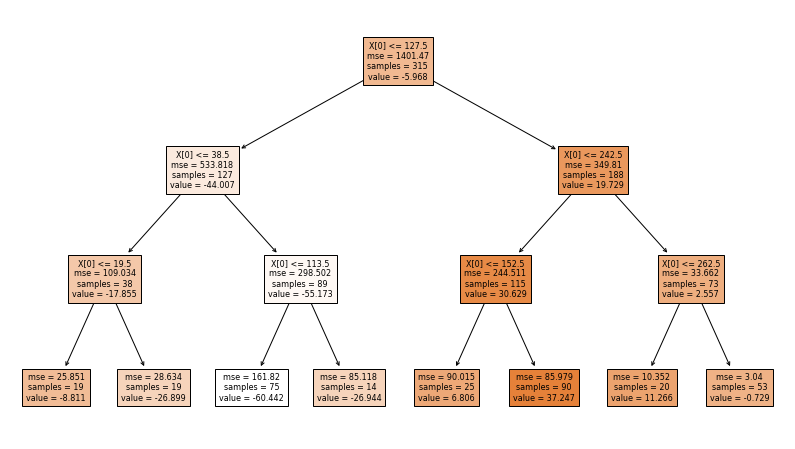

In [107]:
plt.figure(figsize=(14, 8)) 
plt.show(tree.plot_tree(tree_reg_x_1[0],filled=True, fontsize=8))

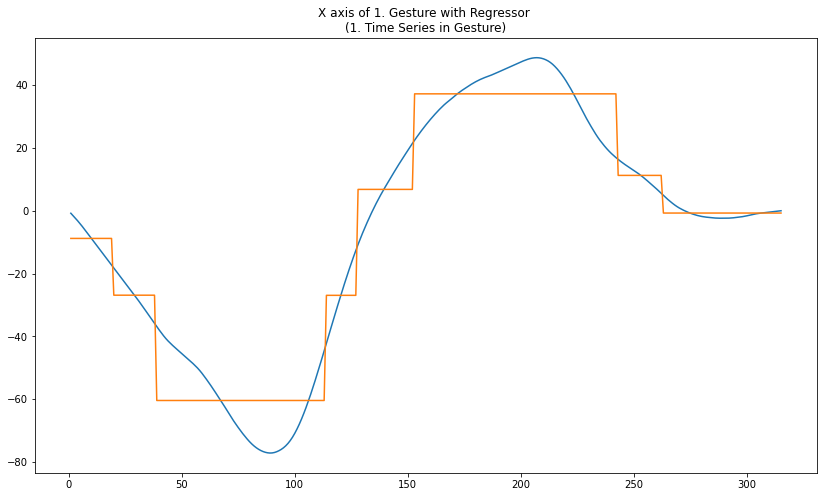

In [108]:
x_1_0_r=visualization_regressor(x_1_r[0], x_1_0_reg_pred, 1, "X", 0)

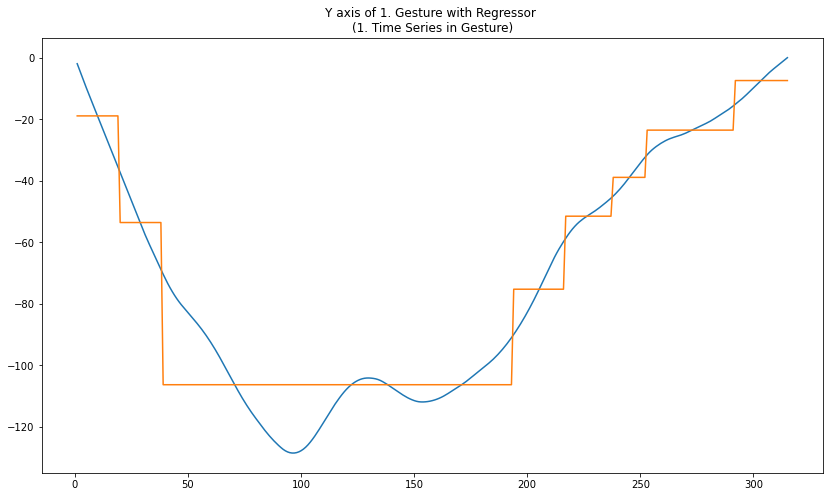

In [109]:
y_1_0_r=visualization_regressor(y_1_r[0], y_1_0_reg_pred, 1, "Y", 0)

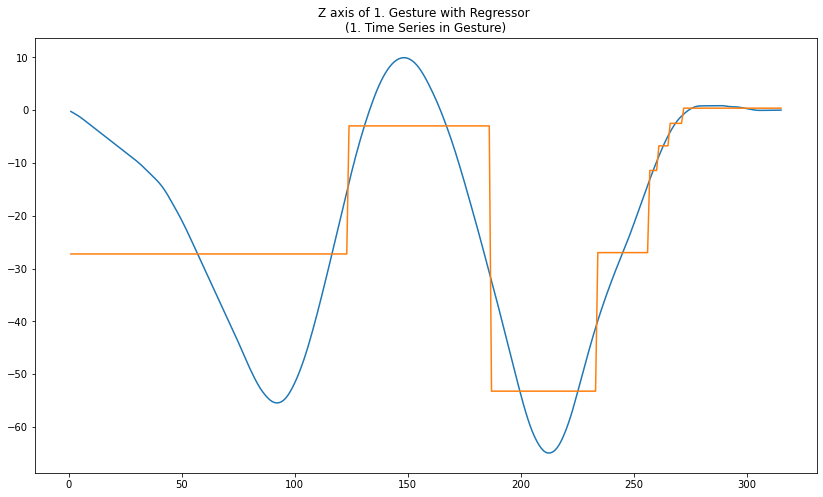

In [110]:
z_1_0_r=visualization_regressor(z_1_r[0], z_1_0_reg_pred, 1, "Z", 0)

# Gesture 2 with Regression Tree

In [111]:
x_2_r=[pd.DataFrame({"time":range(1, len(x_2.T.iloc[:, i])+1), "values":x_2.T.iloc[:, i]}) for i in range(x_2.shape[0])]
y_2_r=[pd.DataFrame({"time":range(1, len(y_2.T.iloc[:, i])+1), "values":y_2.T.iloc[:, i]}) for i in range(y_2.shape[0])]
z_2_r=[pd.DataFrame({"time":range(1, len(z_2.T.iloc[:, i])+1), "values":z_2.T.iloc[:, i]}) for i in range(z_2.shape[0])]

## Individual Decision Models

In [112]:
tree_reg_x_2 = [DecisionTreeRegressor(max_depth=3) for i in range(x_2.shape[0])]
tree_reg_y_2 = [DecisionTreeRegressor(max_depth=3) for i in range(x_2.shape[0])]
tree_reg_z_2 = [DecisionTreeRegressor(max_depth=3) for i in range(x_2.shape[0])]

In [113]:
x_2_0_reg_pred=decision_tree(tree_reg_x_2[0], 0, x_2_r)
y_2_0_reg_pred=decision_tree(tree_reg_y_2[0], 0, y_2_r)
z_2_0_reg_pred=decision_tree(tree_reg_z_2[0], 0, z_2_r)

## PCA for Gesture 2

In [114]:
pca_2 = [pd.DataFrame({"time":x_2_r[i].iloc[:, 0].values,
                         "values_x":x_2_r[i].iloc[:, 1].values,
                         "values_y":y_2_r[i].iloc[:, 1].values,
                         "values_z":z_2_r[i].iloc[:, 1].values,})  for i in range(x_2.shape[0])]

In [115]:
for i in range(len(pca_2)):
    pca=PCA(n_components = 1)
    pca_2[i]["PCA"]=pca.fit_transform(pca_2[i].iloc[:, 1:4])

In [116]:
pca.explained_variance_ratio_

array([0.82045414])

In [117]:
pca.components_.T[:, 0]

array([0.28086265, 0.81655115, 0.50434153])

## Display of Axis

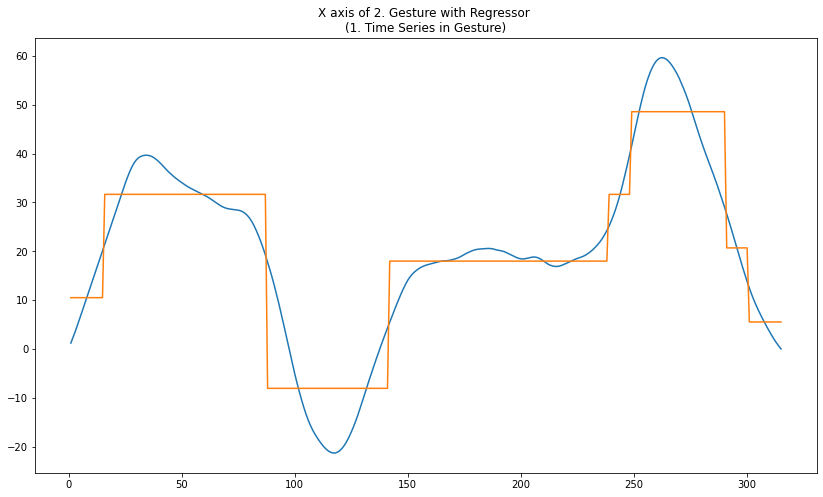

In [118]:
x_2_0_r=visualization_regressor(x_2_r[0], x_2_0_reg_pred, 2, "X", 0)

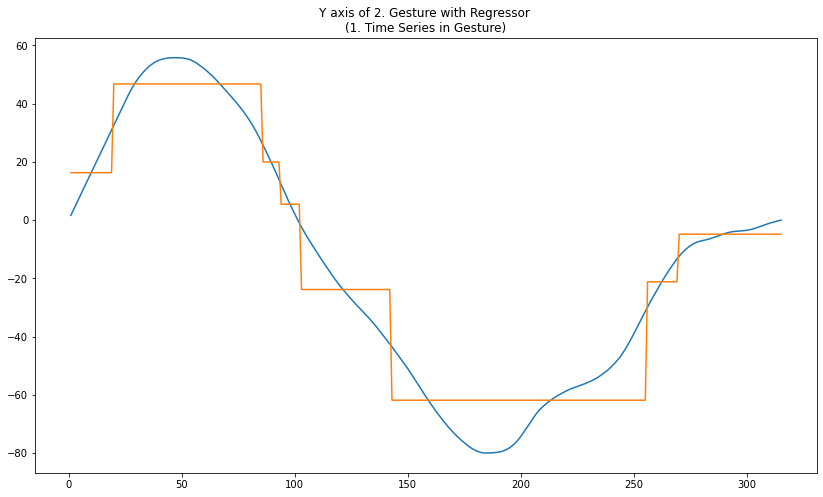

In [119]:
y_2_0_r=visualization_regressor(y_2_r[0], y_2_0_reg_pred, 2, "Y", 0)

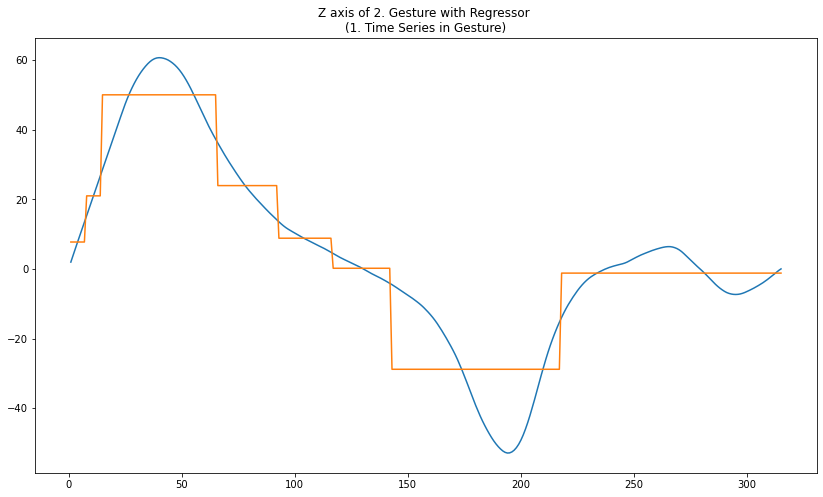

In [120]:
z_2_0_r=visualization_regressor(z_2_r[0], z_2_0_reg_pred, 2, "Z", 0)

# Gesture 3 with Regression Tree

In [121]:
x_3_r=[pd.DataFrame({"time":range(1, len(x_3.T.iloc[:, i])+1), "values":x_3.T.iloc[:, i]}) for i in range(x_3.shape[0])]
y_3_r=[pd.DataFrame({"time":range(1, len(y_3.T.iloc[:, i])+1), "values":y_3.T.iloc[:, i]}) for i in range(y_3.shape[0])]
z_3_r=[pd.DataFrame({"time":range(1, len(z_3.T.iloc[:, i])+1), "values":z_3.T.iloc[:, i]}) for i in range(z_3.shape[0])]

## Individual Decision Models

In [122]:
tree_reg_x_3 = [DecisionTreeRegressor(max_depth=3) for i in range(x_3.shape[0])]
tree_reg_y_3 = [DecisionTreeRegressor(max_depth=3) for i in range(x_3.shape[0])]
tree_reg_z_3 = [DecisionTreeRegressor(max_depth=3) for i in range(x_3.shape[0])]

In [123]:
x_3_0_reg_pred=decision_tree(tree_reg_x_3[0], 0, x_3_r)
y_3_0_reg_pred=decision_tree(tree_reg_y_3[0], 0, y_3_r)
z_3_0_reg_pred=decision_tree(tree_reg_z_3[0], 0, z_3_r)

## PCA for Gesture 3

In [124]:
pca_3 = [pd.DataFrame({"time":x_3_r[i].iloc[:, 0].values,
                         "values_x":x_3_r[i].iloc[:, 1].values,
                         "values_y":y_3_r[i].iloc[:, 1].values,
                         "values_z":z_3_r[i].iloc[:, 1].values,})  for i in range(x_3.shape[0])]

In [125]:
for i in range(len(pca_3)):
    pca=PCA(n_components = 1)
    pca_3[i]["PCA"]=pca.fit_transform(pca_3[i].iloc[:, 1:4])

In [126]:
pca.explained_variance_ratio_

array([0.61629961])

In [127]:
pca.components_.T[:, 0]

array([-0.71875134, -0.00611104,  0.69524037])

## Display of Axis

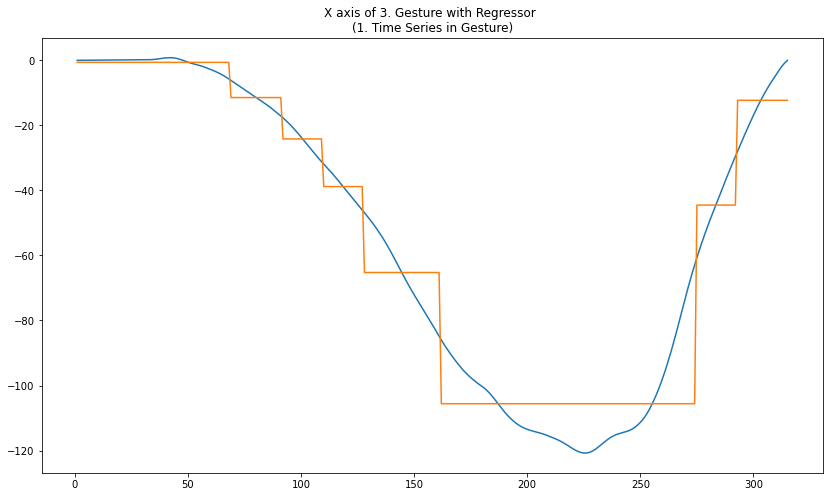

In [128]:
x_3_0_r=visualization_regressor(x_3_r[0], x_3_0_reg_pred, 3, "X", 0)

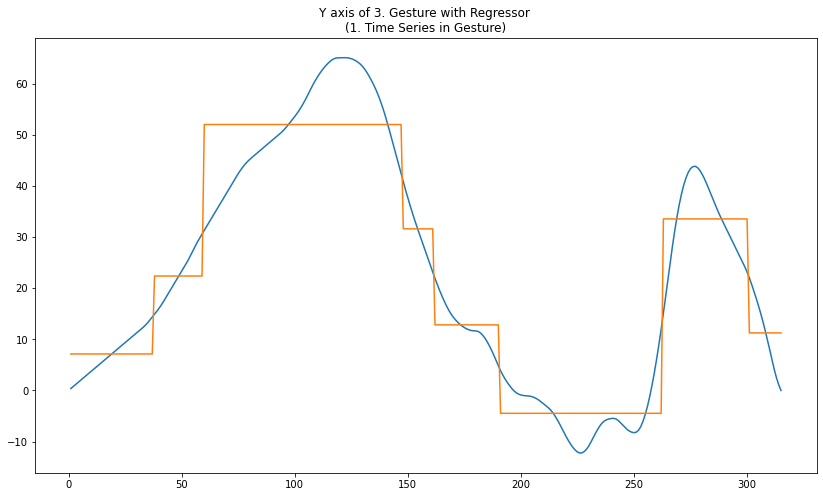

In [129]:
y_3_0_r=visualization_regressor(y_3_r[0], y_3_0_reg_pred, 3, "Y", 0)

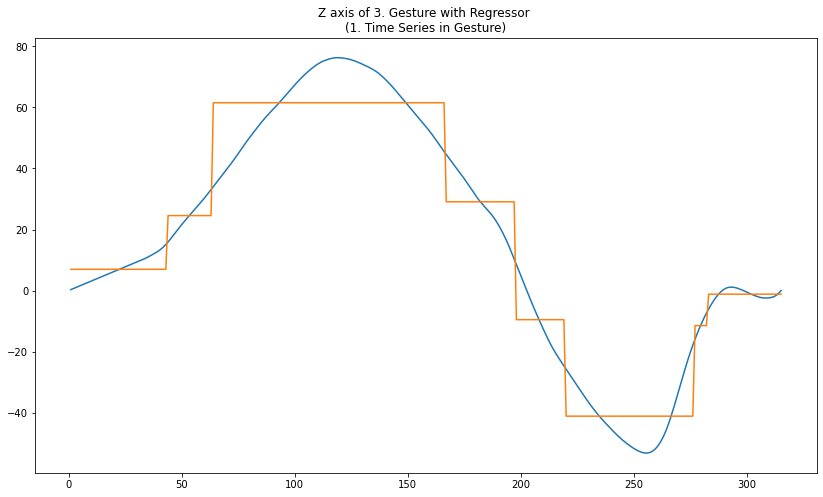

In [130]:
z_3_0_r=visualization_regressor(z_3_r[0], z_3_0_reg_pred, 3, "Z", 0)

# Gesture 4 with Regression Tree

In [131]:
x_4_r=[pd.DataFrame({"time":range(1, len(x_4.T.iloc[:, i])+1), "values":x_4.T.iloc[:, i]}) for i in range(x_4.shape[0])]
y_4_r=[pd.DataFrame({"time":range(1, len(y_4.T.iloc[:, i])+1), "values":y_4.T.iloc[:, i]}) for i in range(y_4.shape[0])]
z_4_r=[pd.DataFrame({"time":range(1, len(z_4.T.iloc[:, i])+1), "values":z_4.T.iloc[:, i]}) for i in range(z_4.shape[0])]

## Individual Decision Models

In [132]:
tree_reg_x_4 = [DecisionTreeRegressor(max_depth=3) for i in range(x_4.shape[0])]
tree_reg_y_4 = [DecisionTreeRegressor(max_depth=3) for i in range(x_4.shape[0])]
tree_reg_z_4 = [DecisionTreeRegressor(max_depth=3) for i in range(x_4.shape[0])]

In [133]:
x_4_0_reg_pred=decision_tree(tree_reg_x_4[0], 0, x_4_r)
y_4_0_reg_pred=decision_tree(tree_reg_y_4[0], 0, y_4_r)
z_4_0_reg_pred=decision_tree(tree_reg_z_4[0], 0, z_4_r)

## PCA for Gesture 4

In [134]:
pca_4 = [pd.DataFrame({"time":x_4_r[i].iloc[:, 0].values,
                         "values_x":x_4_r[i].iloc[:, 1].values,
                         "values_y":y_4_r[i].iloc[:, 1].values,
                         "values_z":z_4_r[i].iloc[:, 1].values,})  for i in range(x_4.shape[0])]

In [135]:
for i in range(len(pca_4)):
    pca=PCA(n_components = 1)
    pca_4[i]["PCA"]=pca.fit_transform(pca_4[i].iloc[:, 1:4])

In [136]:
pca.explained_variance_ratio_

array([0.75848601])

In [137]:
pca.components_.T[:, 0]

array([ 0.52188473,  0.6510052 , -0.55120646])

## Display of Axis

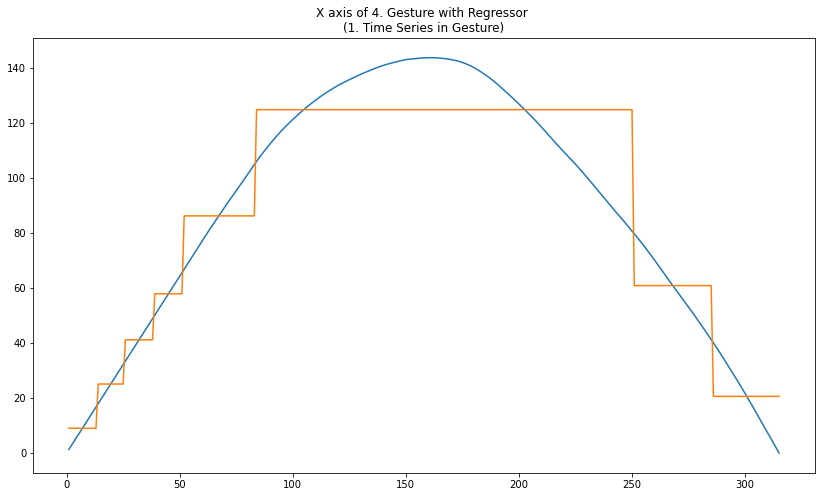

In [138]:
x_4_0_r=visualization_regressor(x_4_r[0], x_4_0_reg_pred, 4, "X", 0)

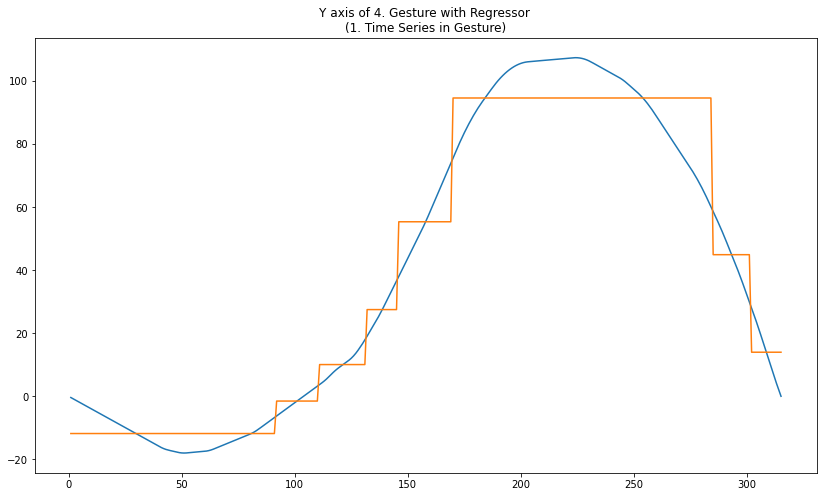

In [139]:
y_4_0_r=visualization_regressor(y_4_r[0], y_4_0_reg_pred, 4, "Y", 0)

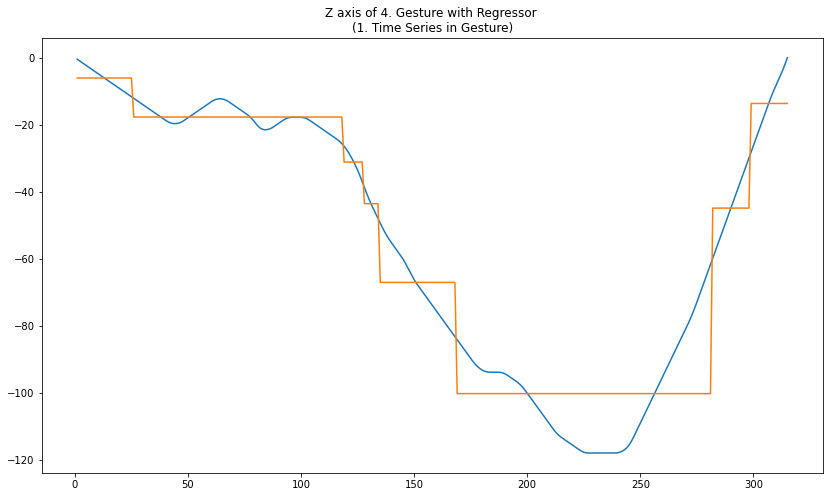

In [140]:
z_4_0_r=visualization_regressor(z_4_r[0], z_4_0_reg_pred, 4, "Z", 0)

# Gesture 5 with Regression Tree

In [141]:
x_5_r=[pd.DataFrame({"time":range(1, len(x_5.T.iloc[:, i])+1), "values":x_5.T.iloc[:, i]}) for i in range(x_5.shape[0])]
y_5_r=[pd.DataFrame({"time":range(1, len(y_5.T.iloc[:, i])+1), "values":y_5.T.iloc[:, i]}) for i in range(y_5.shape[0])]
z_5_r=[pd.DataFrame({"time":range(1, len(z_5.T.iloc[:, i])+1), "values":z_5.T.iloc[:, i]}) for i in range(z_5.shape[0])]

## Individual Decision Models

In [142]:
tree_reg_x_5 = [DecisionTreeRegressor(max_depth=3) for i in range(x_5.shape[0])]
tree_reg_y_5 = [DecisionTreeRegressor(max_depth=3) for i in range(x_5.shape[0])]
tree_reg_z_5 = [DecisionTreeRegressor(max_depth=3) for i in range(x_5.shape[0])]

In [143]:
x_5_0_reg_pred=decision_tree(tree_reg_x_5[0], 0, x_5_r)
y_5_0_reg_pred=decision_tree(tree_reg_y_5[0], 0, y_5_r)
z_5_0_reg_pred=decision_tree(tree_reg_z_5[0], 0, z_5_r)

## PCA for Gesture 5

In [144]:
pca_5 = [pd.DataFrame({"time":x_5_r[i].iloc[:, 0].values,
                         "values_x":x_5_r[i].iloc[:, 1].values,
                         "values_y":y_5_r[i].iloc[:, 1].values,
                         "values_z":z_5_r[i].iloc[:, 1].values,})  for i in range(x_5.shape[0])]

In [145]:
for i in range(len(pca_5)):
    pca=PCA(n_components = 1)
    pca_5[i]["PCA"]=pca.fit_transform(pca_5[i].iloc[:, 1:4])

In [146]:
pca.explained_variance_ratio_

array([0.8633823])

In [147]:
pca.components_.T[:, 0]

array([0.31703741, 0.66748272, 0.67376116])

## Display of Axis

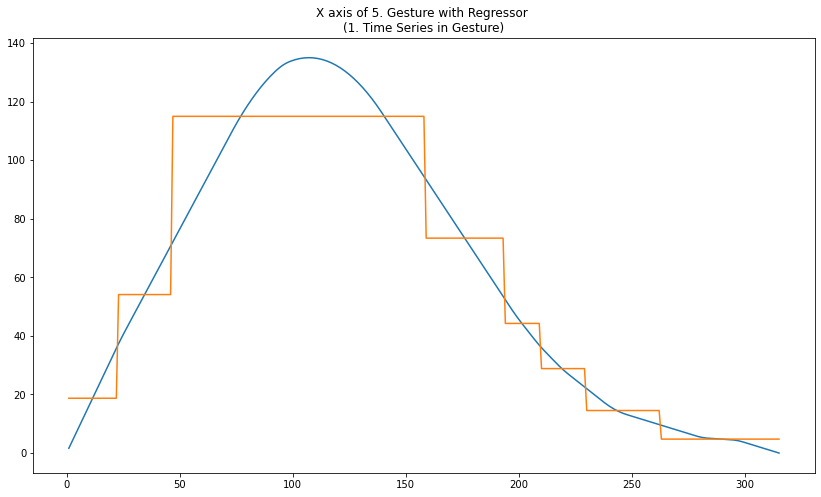

In [148]:
x_5_0_r=visualization_regressor(x_5_r[0], x_5_0_reg_pred, 5, "X", 0)

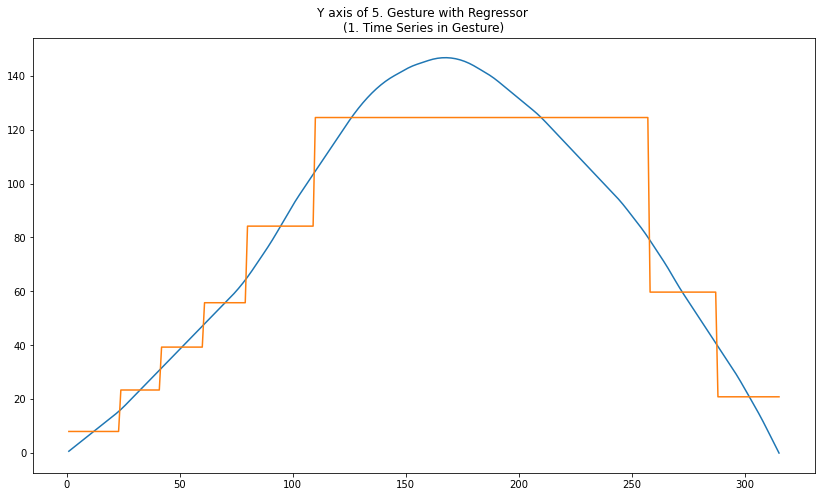

In [149]:
y_5_0_r=visualization_regressor(y_5_r[0], y_5_0_reg_pred, 5, "Y", 0)

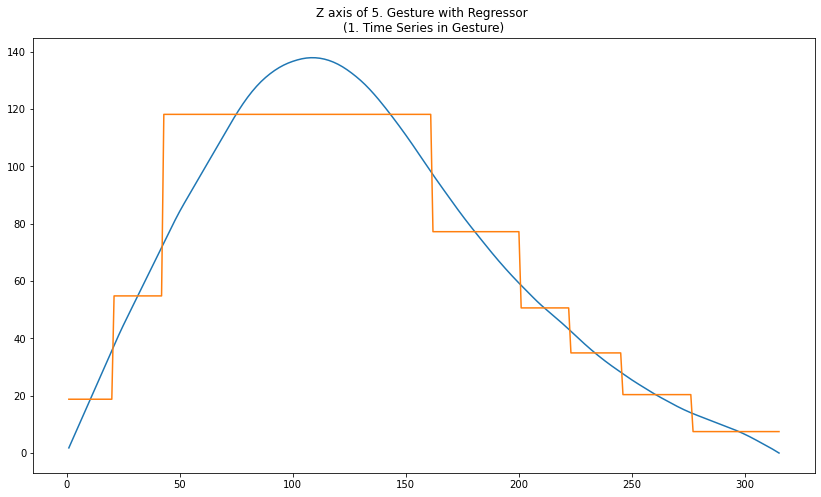

In [150]:
z_5_0_r=visualization_regressor(z_5_r[0], z_5_0_reg_pred, 5, "Z", 0)

# Gesture 6 with Regression Tree

In [151]:
x_6_r=[pd.DataFrame({"time":range(1, len(x_6.T.iloc[:, i])+1), "values":x_6.T.iloc[:, i]}) for i in range(x_6.shape[0])]
y_6_r=[pd.DataFrame({"time":range(1, len(y_6.T.iloc[:, i])+1), "values":y_6.T.iloc[:, i]}) for i in range(y_6.shape[0])]
z_6_r=[pd.DataFrame({"time":range(1, len(z_6.T.iloc[:, i])+1), "values":z_6.T.iloc[:, i]}) for i in range(z_6.shape[0])]

## Individual Decision Models

In [152]:
tree_reg_x_6 = [DecisionTreeRegressor(max_depth=3) for i in range(x_6.shape[0])]
tree_reg_y_6 = [DecisionTreeRegressor(max_depth=3) for i in range(x_6.shape[0])]
tree_reg_z_6 = [DecisionTreeRegressor(max_depth=3) for i in range(x_6.shape[0])]

In [153]:
x_6_0_reg_pred=decision_tree(tree_reg_x_6[0], 0, x_6_r)
y_6_0_reg_pred=decision_tree(tree_reg_y_6[0], 0, y_6_r)
z_6_0_reg_pred=decision_tree(tree_reg_z_6[0], 0, z_6_r)

## PCA for Gesture 6

In [154]:
pca_6 = [pd.DataFrame({"time":x_6_r[i].iloc[:, 0].values,
                         "values_x":x_6_r[i].iloc[:, 1].values,
                         "values_y":y_6_r[i].iloc[:, 1].values,
                         "values_z":z_6_r[i].iloc[:, 1].values,})  for i in range(x_6.shape[0])]

In [155]:
for i in range(len(pca_6)):
    pca=PCA(n_components = 1)
    pca_6[i]["PCA"]=pca.fit_transform(pca_6[i].iloc[:, 1:4])

In [156]:
pca.explained_variance_ratio_

array([0.85800118])

In [157]:
pca.components_.T[:, 0]

array([-0.30939141,  0.69769414,  0.64614228])

## Display of Axis

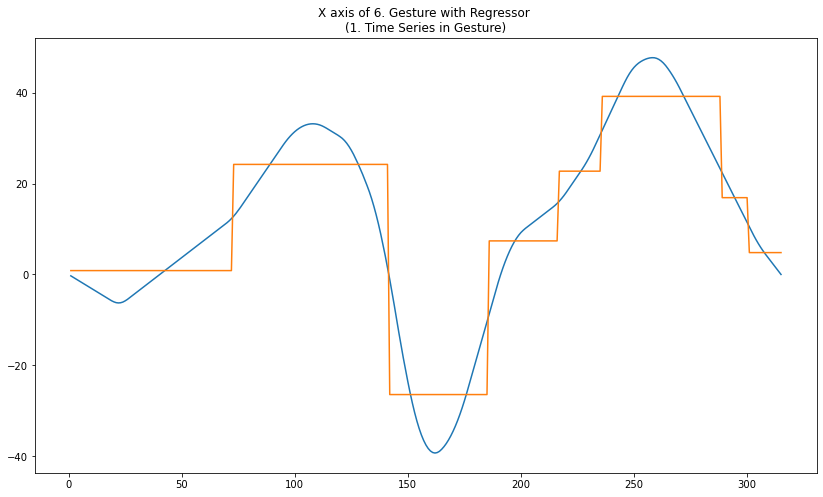

In [158]:
x_6_0_r=visualization_regressor(x_6_r[0], x_6_0_reg_pred, 6, "X", 0)

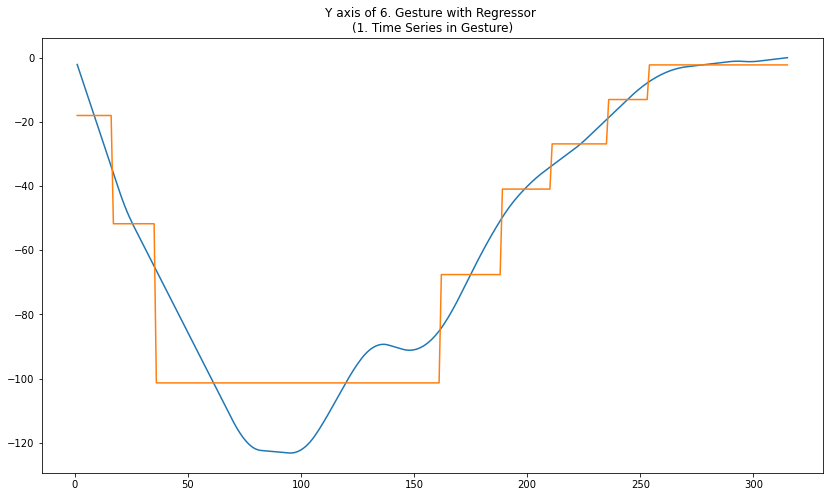

In [159]:
y_6_0_r=visualization_regressor(y_6_r[0], y_6_0_reg_pred, 6, "Y", 0)

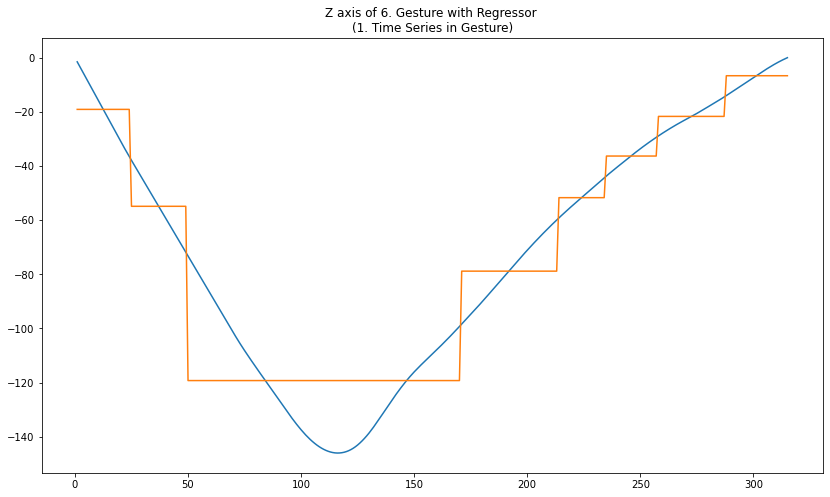

In [160]:
z_6_0_r=visualization_regressor(z_6_r[0], z_6_0_reg_pred, 6, "Z", 0)

# Gesture 7 with Regression Tree

In [161]:
x_7_r=[pd.DataFrame({"time":range(1, len(x_7.T.iloc[:, i])+1), "values":x_7.T.iloc[:, i]}) for i in range(x_7.shape[0])]
y_7_r=[pd.DataFrame({"time":range(1, len(y_7.T.iloc[:, i])+1), "values":y_7.T.iloc[:, i]}) for i in range(y_7.shape[0])]
z_7_r=[pd.DataFrame({"time":range(1, len(z_7.T.iloc[:, i])+1), "values":z_7.T.iloc[:, i]}) for i in range(z_7.shape[0])]

## Individual Decision Models

In [162]:
tree_reg_x_7 = [DecisionTreeRegressor(max_depth=3) for i in range(x_7.shape[0])]
tree_reg_y_7 = [DecisionTreeRegressor(max_depth=3) for i in range(x_7.shape[0])]
tree_reg_z_7 = [DecisionTreeRegressor(max_depth=3) for i in range(x_7.shape[0])]

In [163]:
x_7_0_reg_pred=decision_tree(tree_reg_x_7[0], 0, x_7_r)
y_7_0_reg_pred=decision_tree(tree_reg_y_7[0], 0, y_7_r)
z_7_0_reg_pred=decision_tree(tree_reg_z_7[0], 0, z_7_r)

## PCA for Gesture 7

In [164]:
pca_7 = [pd.DataFrame({"time":x_7_r[i].iloc[:, 0].values,
                         "values_x":x_7_r[i].iloc[:, 1].values,
                         "values_y":y_7_r[i].iloc[:, 1].values,
                         "values_z":z_7_r[i].iloc[:, 1].values,})  for i in range(x_7.shape[0])]

In [165]:
for i in range(len(pca_7)):
    pca=PCA(n_components = 1)
    pca_7[i]["PCA"]=pca.fit_transform(pca_7[i].iloc[:, 1:4])

In [166]:
pca.explained_variance_ratio_

array([0.75109207])

In [167]:
pca.components_.T[:, 0]

array([-0.05074984, -0.67917461, -0.73222012])

## Display of Axis

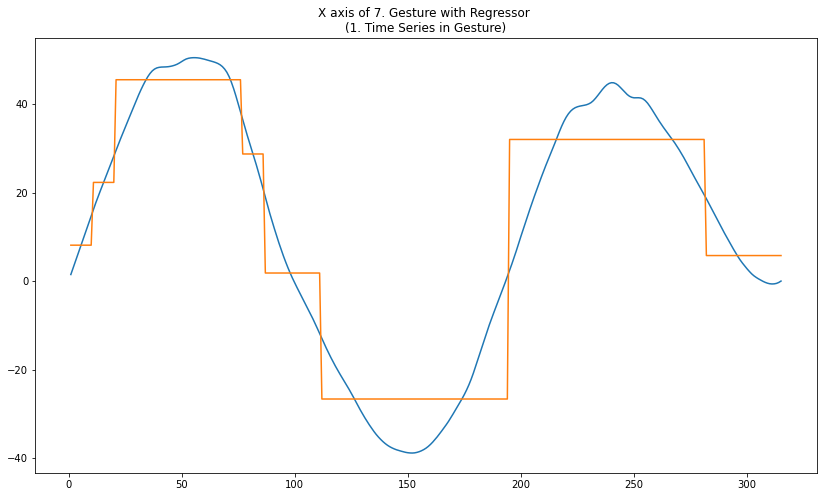

In [168]:
x_7_0_r=visualization_regressor(x_7_r[0], x_7_0_reg_pred, 7, "X", 0)

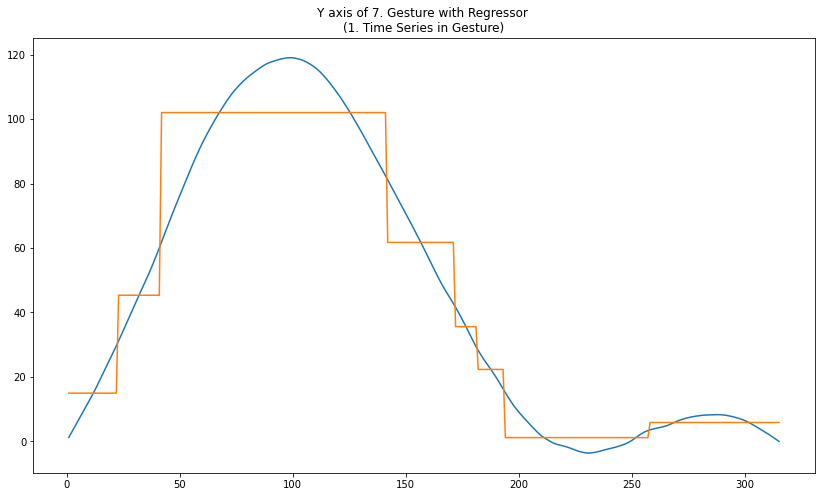

In [169]:
y_7_0_r=visualization_regressor(y_7_r[0], y_7_0_reg_pred, 7, "Y", 0)

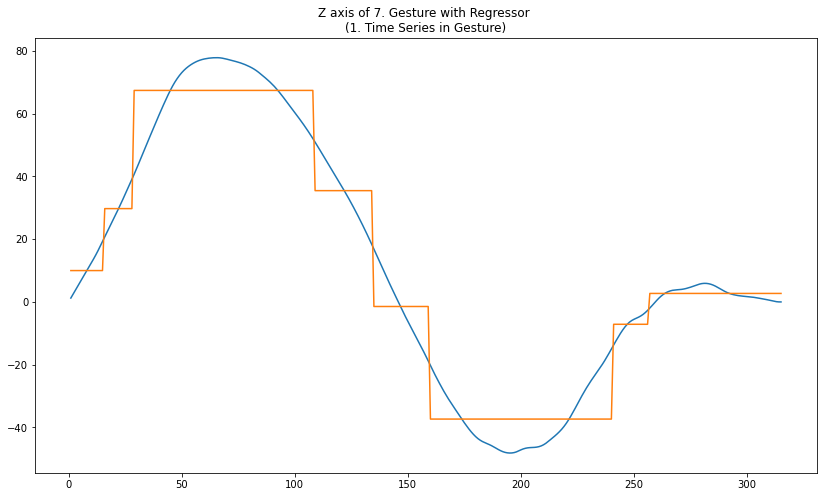

In [170]:
z_7_0_r=visualization_regressor(z_7_r[0], z_7_0_reg_pred, 7, "Z", 0)

# Gesture 8 with Regression Tree

In [171]:
x_8_r=[pd.DataFrame({"time":range(1, len(x_8.T.iloc[:, i])+1), "values":x_8.T.iloc[:, i]}) for i in range(x_8.shape[0])]
y_8_r=[pd.DataFrame({"time":range(1, len(y_8.T.iloc[:, i])+1), "values":y_8.T.iloc[:, i]}) for i in range(y_8.shape[0])]
z_8_r=[pd.DataFrame({"time":range(1, len(z_8.T.iloc[:, i])+1), "values":z_8.T.iloc[:, i]}) for i in range(z_8.shape[0])]

## Individual Decision Models

In [172]:
tree_reg_x_8 = [DecisionTreeRegressor(max_depth=3) for i in range(x_8.shape[0])]
tree_reg_y_8 = [DecisionTreeRegressor(max_depth=3) for i in range(x_8.shape[0])]
tree_reg_z_8 = [DecisionTreeRegressor(max_depth=3) for i in range(x_8.shape[0])]

In [173]:
x_8_0_reg_pred=decision_tree(tree_reg_x_8[0], 0, x_8_r)
y_8_0_reg_pred=decision_tree(tree_reg_y_8[0], 0, y_8_r)
z_8_0_reg_pred=decision_tree(tree_reg_z_8[0], 0, z_8_r)

## PCA for Gesture 8

In [174]:
pca_8 = [pd.DataFrame({"time":x_8_r[i].iloc[:, 0].values,
                         "values_x":x_8_r[i].iloc[:, 1].values,
                         "values_y":y_8_r[i].iloc[:, 1].values,
                         "values_z":z_8_r[i].iloc[:, 1].values,})  for i in range(x_8.shape[0])]

In [175]:
for i in range(len(pca_8)):
    pca=PCA(n_components = 1)
    pca_8[i]["PCA"]=pca.fit_transform(pca_8[i].iloc[:, 1:4])

In [176]:
pca.explained_variance_ratio_

array([0.54634702])

In [177]:
pca.components_.T[:, 0]

array([ 0.87201588,  0.48847628, -0.03129264])

## Display of Axis

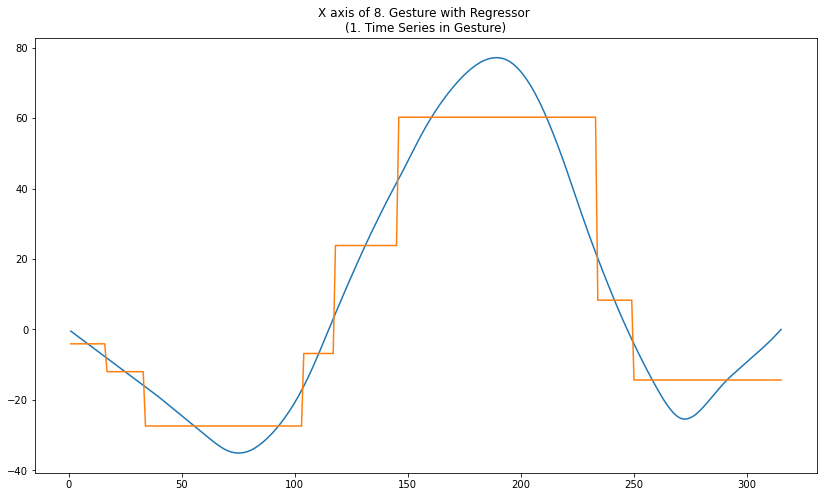

In [178]:
x_8_0_r=visualization_regressor(x_8_r[0], x_8_0_reg_pred, 8, "X", 0)

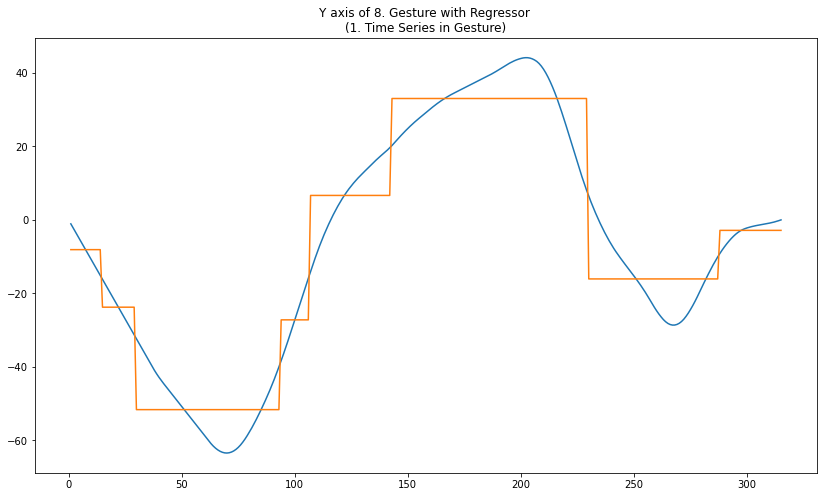

In [179]:
y_8_0_r=visualization_regressor(y_8_r[0], y_8_0_reg_pred, 8, "Y", 0)

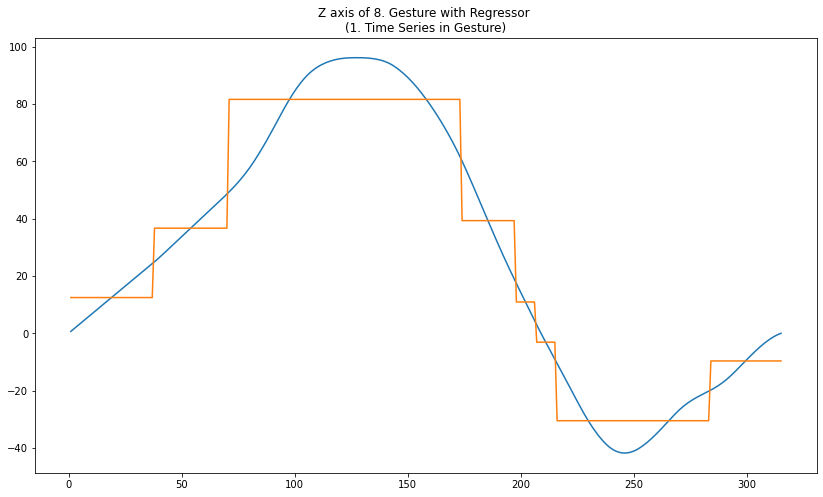

In [180]:
z_8_0_r=visualization_regressor(z_8_r[0], z_8_0_reg_pred, 8, "Z", 0)

Performance of Regressor

# Regression Tree to Find Piecewise Models on PCA

Neden bunu yaptım

In [181]:
def decision_tree_pca(dataset):
    model=DecisionTreeRegressor(max_depth=3)
    time=dataset[["time"]]
    values=dataset[["PCA"]]
    model.fit(time, values)
    
    predictions=model.predict(time)
    
    return predictions

In [182]:
pca_names= [pca_1, pca_2, pca_3, pca_4, pca_5, pca_6, pca_7, pca_8]

In [183]:
for pca_data in pca_names:
    for j in range(2):
        pca_data[j]["predictions"]=decision_tree_pca(pca_data[j])

<a id="5"></a>
# Gesture Recognation Perspective

In [184]:
import seaborn as sns

In [185]:
sns.set(rc={'figure.figsize':(16,16)})

## String to Value

In [186]:
def string_to_value(dataset):
    values=[]
    key_values = {"a": (1/7)*0, "b": (1/7)*1, "c":(1/7)*2, "d": (1/7)*3, "e": (1/7)*4, "f":(1/7)*5, "g": (1/7)*6, "h":(1/7)*7}
    for i in range(len(dataset)):
        values.append(key_values.get(dataset["String"][i]))
    
    return(values)

## DataFrame for String

In [187]:
string_datasets=[string_data_1, string_data_2, string_data_3, string_data_4,
                 string_data_5, string_data_6, string_data_7, string_data_8]

In [188]:
string_gesture=[]
string_id=[]
string_vote=[]
time=[]
gesture_no=1
for dt in string_datasets:    
    for j in range(2):
        sequence=1
        for k in range(len(dt[j])):
            time.append(sequence)
            string_gesture.append(gesture_no)
            string_id.append(j)
            string_vote.append(dt[j]["hard_voting"][k])
            sequence+=1
    gesture_no+=1
    

In [189]:
string_dt=pd.DataFrame({"Gesture No": string_gesture, "ID": string_id, "Time":time, "String": string_vote})

In [190]:
string_dt["string_values"]=string_to_value(string_dt)

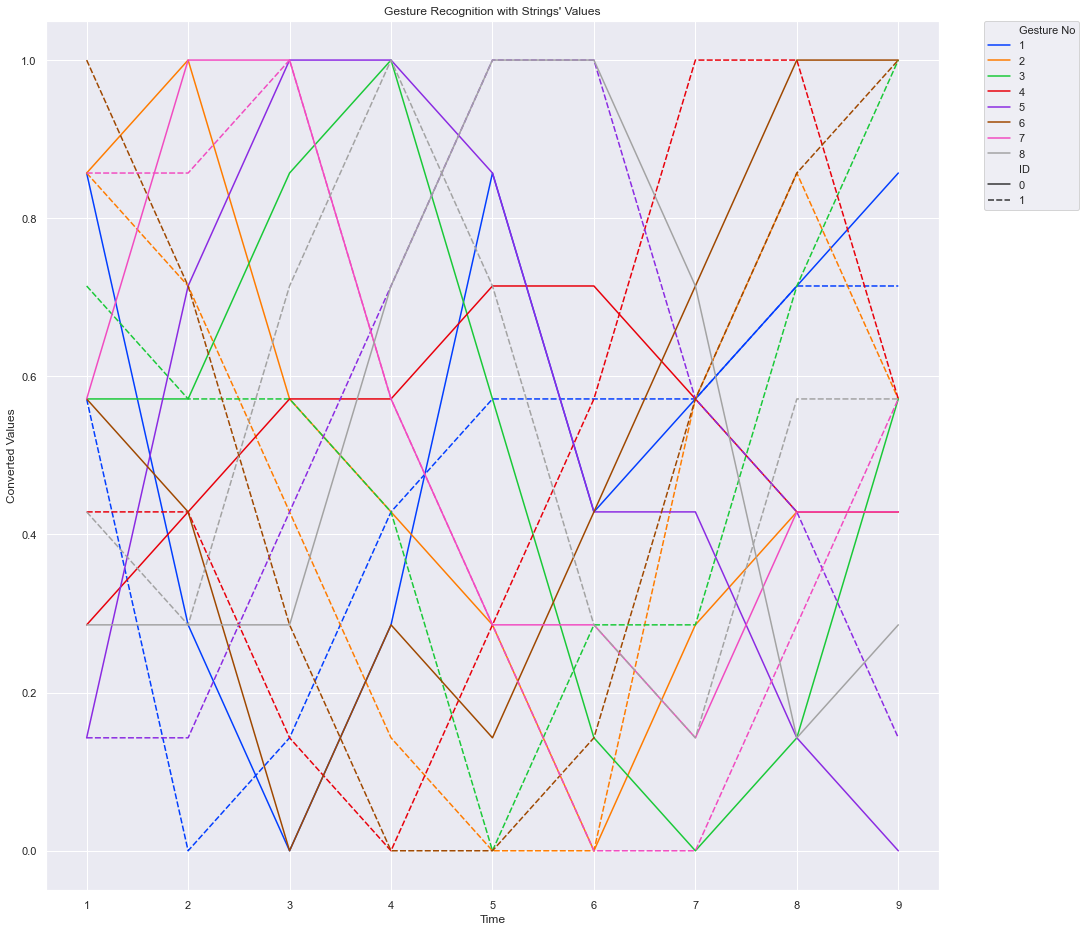

In [191]:
palette = sns.color_palette("bright", 8) 
ax = sns.lineplot(x="Time", y="string_values", style="ID", hue="Gesture No", 
             data=string_dt, palette=palette)
ax.set_title("Gesture Recognition with Strings' Values")
ax.set_ylabel("Converted Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Reduced Gesture Recognition

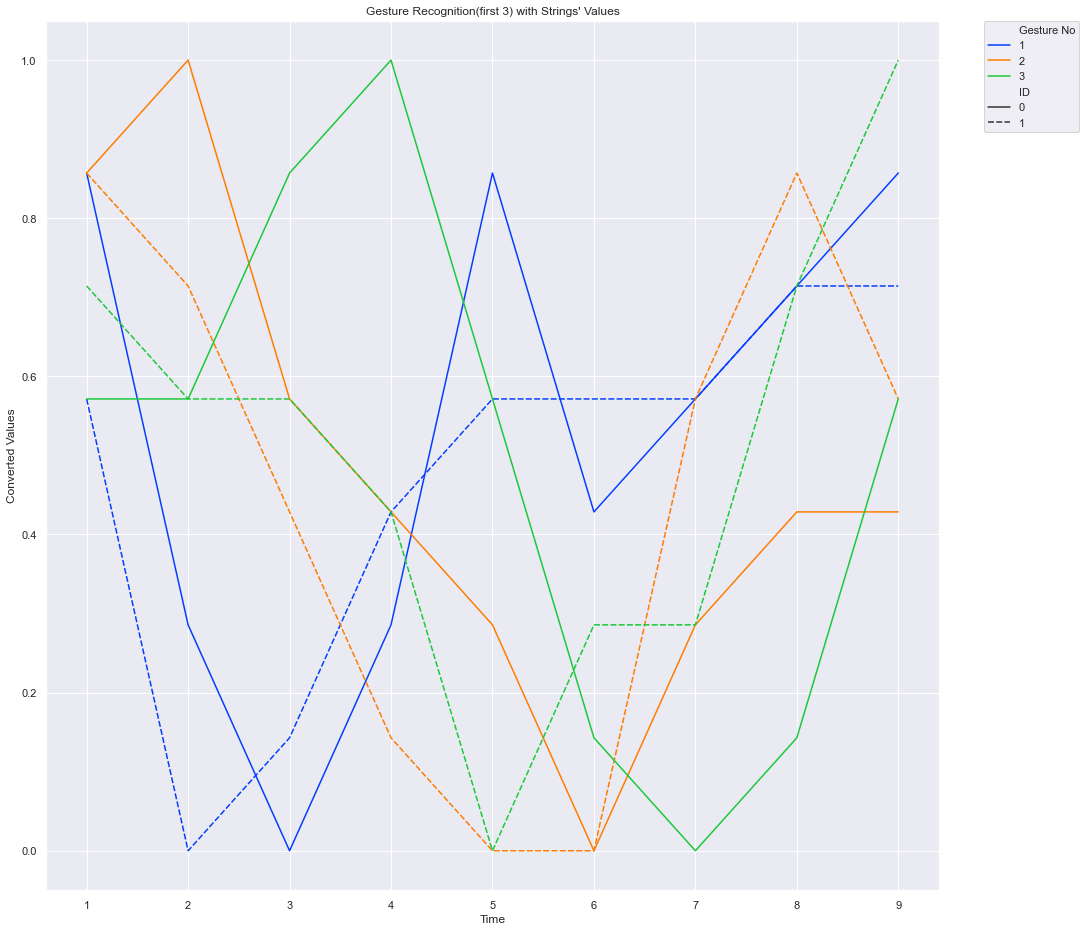

In [192]:
palette_3 = sns.color_palette("bright", 3) 
ax = sns.lineplot(x="Time", y="string_values", style="ID", hue="Gesture No", 
             data=string_dt[string_dt["Gesture No"]<=3], palette=palette_3)
ax.set_title("Gesture Recognition(first 3) with Strings' Values")
ax.set_ylabel("Converted Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# DataFrame for Regressors

In [193]:
from sklearn.preprocessing import MinMaxScaler

In [194]:
scaler=MinMaxScaler()

## Value Normalization

In [195]:
def scaler_to_1(dataset):   
    scaled=[]
    
    for i in range(8):
        current_dt=dataset[dataset["Gesture No"]==i+1]       
        for j in range(2):
            last_dt=current_dt[current_dt["ID"]==j]
            current_list=scaler.fit_transform(last_dt[["PCA Values"]]).reshape(-1)
            for k in range(len(current_list)):
                scaled.append(current_list[k])
    return(scaled)

## DataFrame for String

In [196]:
pca_datasets=[pca_1, pca_2, pca_3, pca_4,
                 pca_5, pca_6, pca_7, pca_8]

In [197]:
pca_gesture=[]
pca_id=[]
pca_value=[]
time=[]
gesture_no=1
for dt in pca_datasets:    
    for j in range(2):
        sequence=1
        for k in range(len(dt[j])):
            time.append(sequence)
            pca_gesture.append(gesture_no)
            pca_id.append(j)
            pca_value.append(dt[j]["predictions"][k])
            sequence+=1
    gesture_no+=1
    

In [198]:
pca_dt=pd.DataFrame({"Gesture No": pca_gesture, "ID": pca_id, "Time":time, "PCA Values": pca_value})

In [199]:
pca_dt["Scaled Values"]=scaler_to_1(pca_dt)

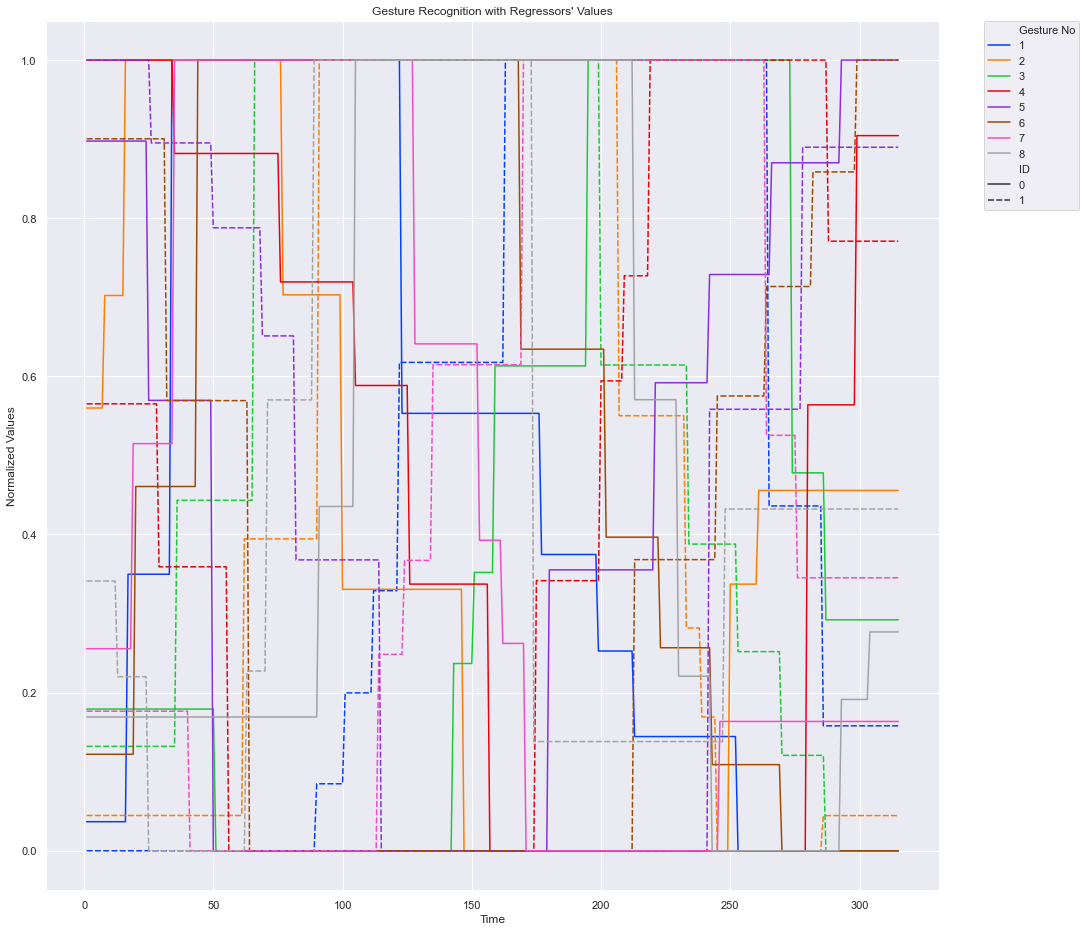

In [200]:
ax = sns.lineplot(x="Time", y="Scaled Values", style="ID", hue="Gesture No", 
             data=pca_dt, palette=palette)
ax.set_title("Gesture Recognition with Regressors' Values")
ax.set_ylabel("Normalized Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Reduced Gesture Recognition

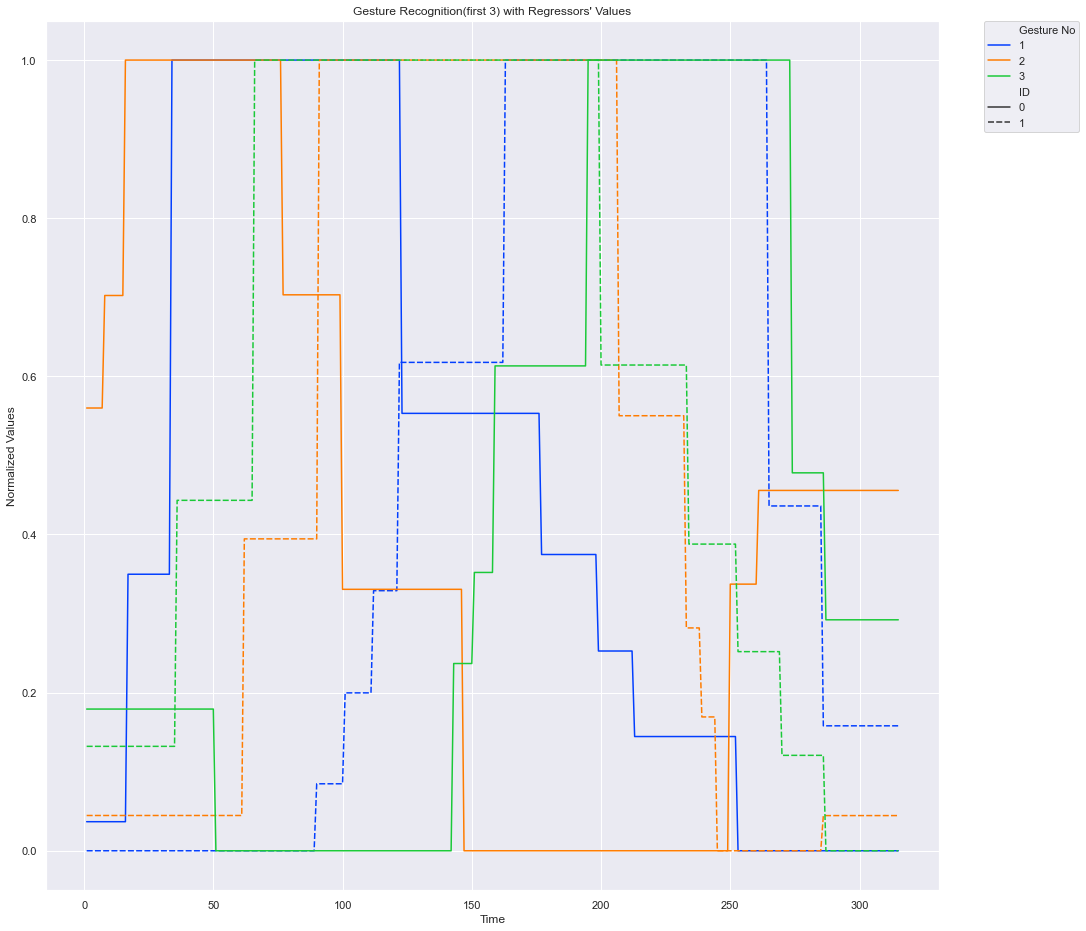

In [201]:
ax = sns.lineplot(x="Time", y="Scaled Values", style="ID", hue="Gesture No", 
             data=pca_dt[pca_dt["Gesture No"]<=3], palette=palette_3)
ax.set_title("Gesture Recognition(first 3) with Regressors' Values")
ax.set_ylabel("Normalized Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()